# stroke-alert

**Predictable variable: stroke**  
We are aiming to early predict and alert the stroke risk based on individual's demographical and health data.

##### Libraries : 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.feature_selection import RFE,RFECV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, classification_report
from scipy.stats import pointbiserialr, chi2_contingency, ttest_ind
from sklearn.utils import resample
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import classification_report
from sklearn import model_selection
from sklearn import neighbors
from sklearn import svm
import matplotlib.pyplot as plt
%matplotlib inline

##### Original data:

Making a copy of original dataframe - "df_original"

In [2]:
df = pd.read_csv("AVC.csv")
df_original = df.copy()
df.head()

id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Data has:  
1 independent variable **stroke**,  
10 dependent variables (id is not dependent variable):  
- 3 continuous variables - **age**, **bmi**, **avg_glucose_level**  
- 7 categorical variables:  
  - 2 binary variables - **hypertension**, **heart_disease**
  - 5 nominal variables - **gender**, **ever_married**, **work_type**, **Residence_type**, **smoking_status**  
  
**Data has missing bmi values.**  

Converting categorical variables to numerical representations

In [4]:
categorical_vars = ['gender', 'hypertension', 'heart_disease', 'ever_married',
                    'work_type', 'Residence_type', 'smoking_status', 'stroke']

# Apply label encoding to the categorical variables
encoder = LabelEncoder()
df[categorical_vars] = df[categorical_vars].apply(encoder.fit_transform)

### Stroke (imbalanced)

Data distribution:

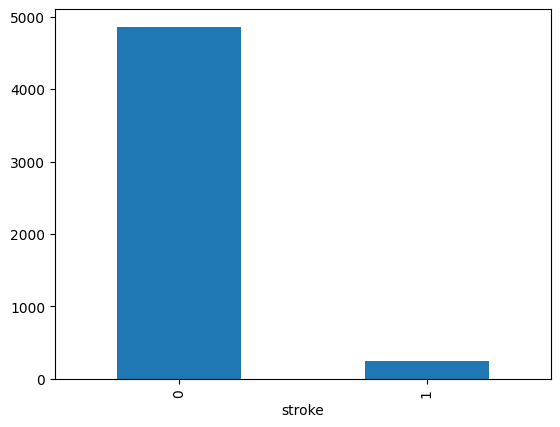

In [5]:
df.stroke.value_counts().plot(kind='bar')
plt.show()

There is a high imbalance in the data between the positive and negative stroke classes.

In [6]:
df.stroke.value_counts()

stroke
0    4861
1     249
Name: count, dtype: int64

In [7]:
stroke_percentage = 249*100/(249+4861)
round(stroke_percentage, 2)

4.87

Around **95%** of data records are in stroke class 0.

Since there are null bmi values, dealing with these missing values is an essential step to address before proceeding further to balancing classes.

### Gender (imbalanced)

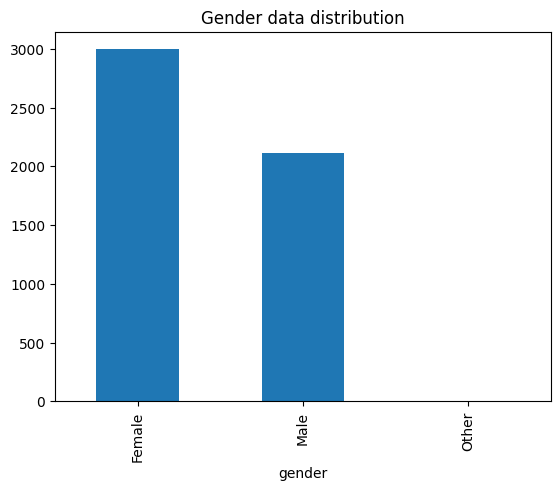

In [8]:
df_original.gender.value_counts().plot(kind='bar')
plt.title('Gender data distribution')
plt.show()

In [9]:
df_gender_other = df[df['gender'] == 2]
df_gender_other

id  gender   age  hypertension  heart_disease  ever_married  \
3116  56156       2  26.0             0              0             0   

      work_type  Residence_type  avg_glucose_level   bmi  smoking_status  \
3116          2               0             143.33  22.4               1   

      stroke  
3116       0

One record in Other gender class can be deleted as it is also in Negative stroke class.

In [10]:
df = df[df['gender'] != 2]

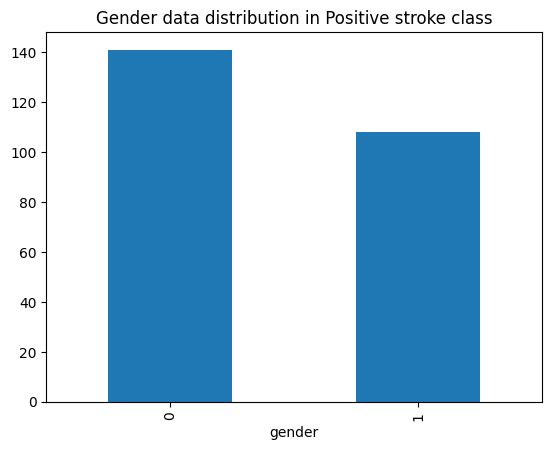

In [11]:
df_stroke = df[df['stroke'] == 1]
df_stroke.gender.value_counts().plot(kind='bar')
plt.title('Gender data distribution in Positive stroke class')
plt.show()

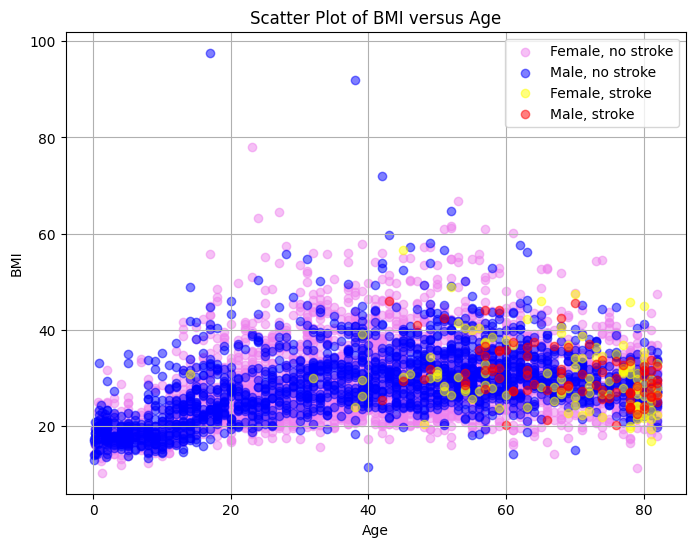

In [12]:
plt.figure(figsize=(8, 6))
plt.scatter(df[(df['gender'] == 0) & (df['stroke'] == 0)]['age'], df[(df['gender'] == 0) & (df['stroke'] == 0)]['bmi'], color='violet', alpha=0.5, label='Female, no stroke')
plt.scatter(df[(df['gender'] == 1) & (df['stroke'] == 0)]['age'], df[(df['gender'] == 1) & (df['stroke'] == 0)]['bmi'], color='blue', alpha=0.5, label='Male, no stroke')
plt.scatter(df[(df['gender'] == 0) & (df['stroke'] == 1)]['age'], df[(df['gender'] == 0) & (df['stroke'] == 1)]['bmi'], color='yellow', alpha=0.5, label='Female, stroke')
plt.scatter(df[(df['gender'] == 1) & (df['stroke'] == 1)]['age'], df[(df['gender'] == 1) & (df['stroke'] == 1)]['bmi'], color='red', alpha=0.5, label='Male, stroke')
plt.title('Scatter Plot of BMI versus Age')
plt.xlabel('Age')
plt.ylabel('BMI')
plt.grid(True)
plt.legend()
plt.show()

In [13]:
bmi_male = df[df['gender'] == 0]['bmi']
bmi_female = df[df['gender'] == 1]['bmi']

t_statistic, p_value = ttest_ind(bmi_male, bmi_female)

print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: nan
P-value: nan


p-value is 0.0298, which is less than 0.05. This suggests that there is a significant difference between the BMI values of males and females.

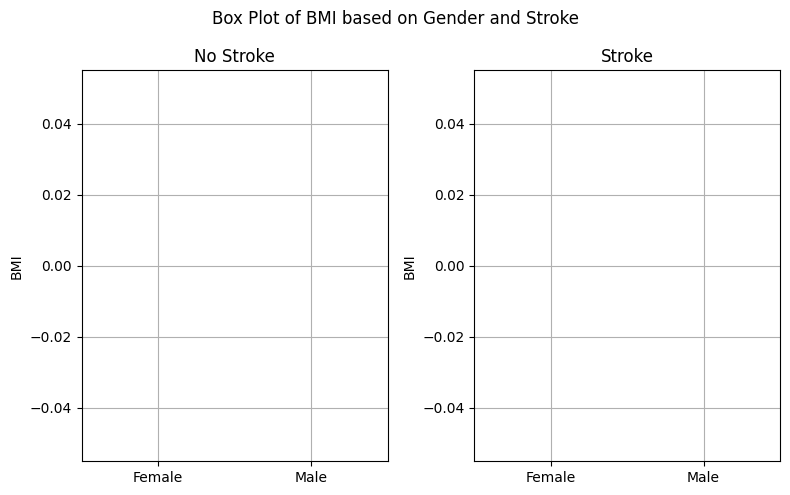

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(8, 5))
axs[0].boxplot([df[(df['gender'] == 0) & (df['stroke'] == 0)]['bmi'], df[(df['gender'] == 1) & (df['stroke'] == 0)]['bmi']])
axs[0].set_title('No Stroke')

axs[1].boxplot([df[(df['gender'] == 0) & (df['stroke'] == 1)]['bmi'], df[(df['gender'] == 1) & (df['stroke'] == 1)]['bmi']])
axs[1].set_title('Stroke')

for ax in axs:
    ax.set_xticklabels(['Female', 'Male'])

for ax in axs:
    ax.set_ylabel('BMI')
    ax.grid(True)

plt.suptitle('Box Plot of BMI based on Gender and Stroke')
plt.tight_layout()
plt.show()


BMI index in the female positive stroke class is lower than in the male positive stroke class. Also, the range of BMI values for females is larger than for males.

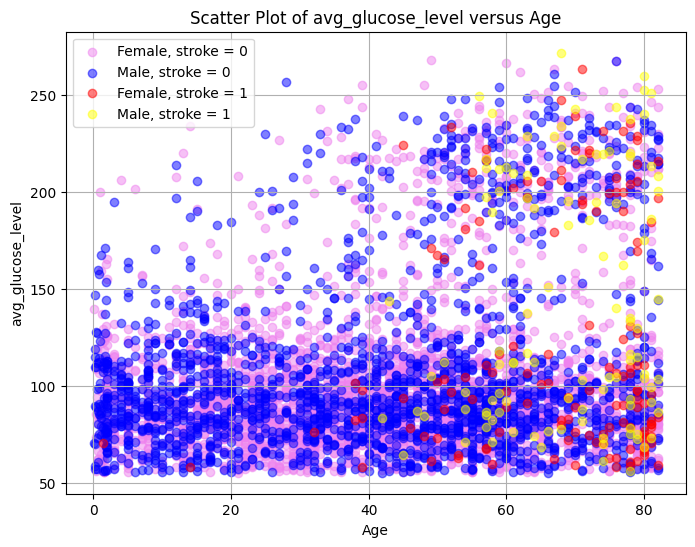

In [15]:
plt.figure(figsize=(8, 6))
plt.scatter(df[(df['gender'] == 0) & (df['stroke'] == 0)]['age'], df[(df['gender'] == 0) & (df['stroke'] == 0)]['avg_glucose_level'], color='violet', alpha=0.5, label='Female, stroke = 0')
plt.scatter(df[(df['gender'] == 1) & (df['stroke'] == 0)]['age'], df[(df['gender'] == 1) & (df['stroke'] == 0)]['avg_glucose_level'], color='blue', alpha=0.5, label='Male, stroke = 0')
plt.scatter(df[(df['gender'] == 0) & (df['stroke'] == 1)]['age'], df[(df['gender'] == 0) & (df['stroke'] == 1)]['avg_glucose_level'], color='red', alpha=0.5, label='Female, stroke = 1')
plt.scatter(df[(df['gender'] == 1) & (df['stroke'] == 1)]['age'], df[(df['gender'] == 1) & (df['stroke'] == 1)]['avg_glucose_level'], color='yellow', alpha=0.5, label='Male, stroke = 1')
plt.title('Scatter Plot of avg_glucose_level versus Age')
plt.xlabel('Age')
plt.ylabel('avg_glucose_level')
plt.grid(True)
plt.legend()
plt.show()

In [16]:
bmi_male = df[df['gender'] == 0]['avg_glucose_level']
bmi_female = df[df['gender'] == 1]['avg_glucose_level']

t_statistic, p_value = ttest_ind(bmi_male, bmi_female)

print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: -3.9164881406207983
P-value: 9.102045606394271e-05


p-value is 0.00, which suggests that there is a significant difference between the avg glucose level values of males and females.

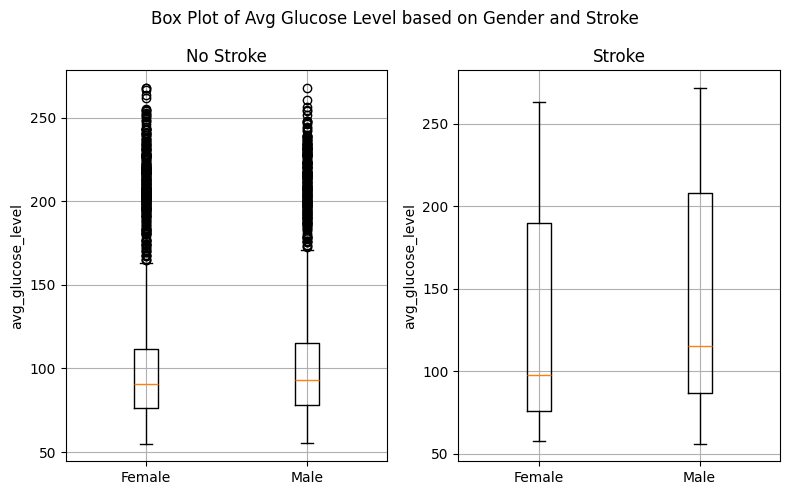

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(8, 5))
axs[0].boxplot([df[(df['gender'] == 0) & (df['stroke'] == 0)]['avg_glucose_level'], df[(df['gender'] == 1) & (df['stroke'] == 0)]['avg_glucose_level']])
axs[0].set_title('No Stroke')

axs[1].boxplot([df[(df['gender'] == 0) & (df['stroke'] == 1)]['avg_glucose_level'], df[(df['gender'] == 1) & (df['stroke'] == 1)]['avg_glucose_level']])
axs[1].set_title('Stroke')

for ax in axs:
    ax.set_xticklabels(['Female', 'Male'])

for ax in axs:
    ax.set_ylabel('avg_glucose_level')
    ax.grid(True)

plt.suptitle('Box Plot of Avg Glucose Level based on Gender and Stroke')
plt.tight_layout()
plt.show()

Average Glucose Level in the female positive stroke class is also lower than in the males. Additionally, the range of Average Glucose Level values for females is larger than for males.

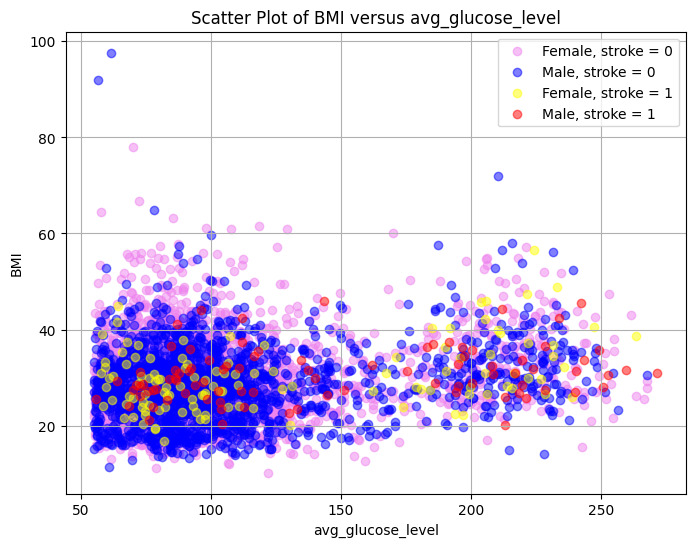

In [18]:
plt.figure(figsize=(8, 6))
plt.scatter(df[(df['gender'] == 0) & (df['stroke'] == 0)]['avg_glucose_level'], df[(df['gender'] == 0) & (df['stroke'] == 0)]['bmi'], color='violet', alpha=0.5, label='Female, stroke = 0')
plt.scatter(df[(df['gender'] == 1) & (df['stroke'] == 0)]['avg_glucose_level'], df[(df['gender'] == 1) & (df['stroke'] == 0)]['bmi'], color='blue', alpha=0.5, label='Male, stroke = 0')
plt.scatter(df[(df['gender'] == 0) & (df['stroke'] == 1)]['avg_glucose_level'], df[(df['gender'] == 0) & (df['stroke'] == 1)]['bmi'], color='yellow', alpha=0.5, label='Female, stroke = 1')
plt.scatter(df[(df['gender'] == 1) & (df['stroke'] == 1)]['avg_glucose_level'], df[(df['gender'] == 1) & (df['stroke'] == 1)]['bmi'], color='red', alpha=0.5, label='Male, stroke = 1')
plt.title('Scatter Plot of BMI versus avg_glucose_level')
plt.xlabel('avg_glucose_level')
plt.ylabel('BMI')
plt.grid(True)
plt.legend()
plt.show()

### Age

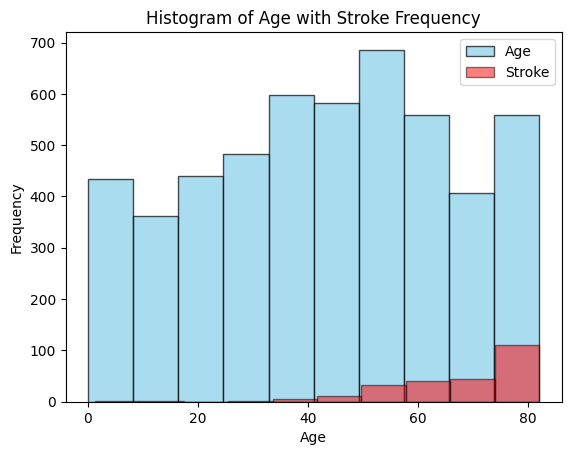

In [19]:
number_of_bins = 10
plt.hist(df['age'], bins=number_of_bins, color='skyblue', alpha=0.7, edgecolor='black', label='Age')
plt.hist(df[df['stroke'] == 1]['age'], bins=number_of_bins, color='red', alpha=0.5, edgecolor='black', label='Stroke')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of Age with Stroke Frequency')
plt.legend()
plt.show()

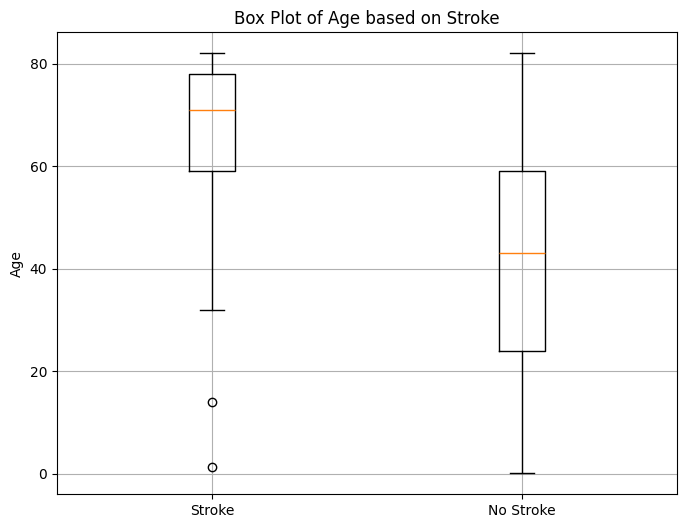

In [20]:
plt.figure(figsize=(8, 6))
plt.boxplot([df[df['stroke'] == 1]['age'], df[df['stroke'] == 0]['age']], labels=['Stroke', 'No Stroke'])
plt.ylabel('Age')
plt.title('Box Plot of Age based on Stroke')
plt.grid(True)
plt.show()

In [21]:
stroke_data = df[df['stroke'] == 1]['age']

# Calculate the 25th percentile (Q1)
Q1 = np.percentile(stroke_data, 25)

# Calculate the interquartile range (IQR)
IQR = np.percentile(stroke_data, 75) - Q1

# Calculate the lower bound for outliers
lower_bound = Q1 - 1.5 * IQR

# Find the minimum value excluding outliers
minimum_stroke = stroke_data[stroke_data >= lower_bound].min()

print("Minimum age for strokes excluding outliers:", minimum_stroke)

Minimum age for strokes excluding outliers: 32.0


Deleting records where age is <= 30

In [22]:
df = df.drop(df[df['age'] <= 30].index)

### BMI

Calculating null bmi values:

In [23]:
df_bmi_unknown = df[df['bmi'].isnull()]
print(len(df_bmi_unknown))

167


**There are 195 empty BMI values**

Data distribution:

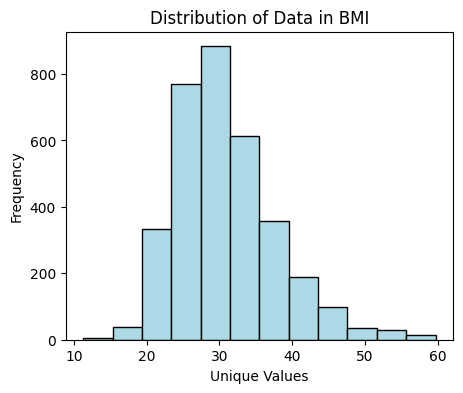

In [24]:
df_original_bmi_cleaned = df.drop(df[(df['bmi'] > 60)].index)
plt.figure(figsize=(5, 4))
plt.hist(df_original_bmi_cleaned['bmi'], bins=12, color='lightblue', edgecolor='black')
plt.title('Distribution of Data in BMI')
plt.xlabel('Unique Values')
plt.ylabel('Frequency')
plt.show()

Data distribution and outliers:

BMI values are distrubuted fine.

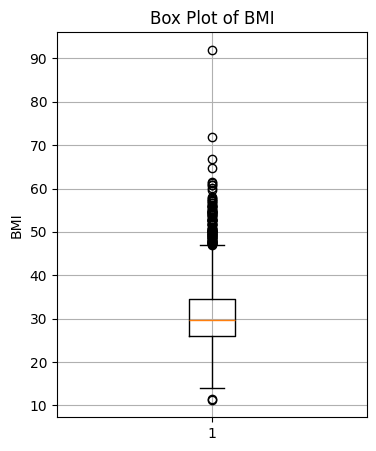

In [25]:
df_bmi = df[df['bmi'].notnull()]
plt.figure(figsize=(4, 5))
plt.boxplot(df_bmi['bmi'])
plt.ylabel('BMI')
plt.title('Box Plot of BMI')
plt.grid(True)
plt.show()

Data distribution and outliers in both stroke classes:

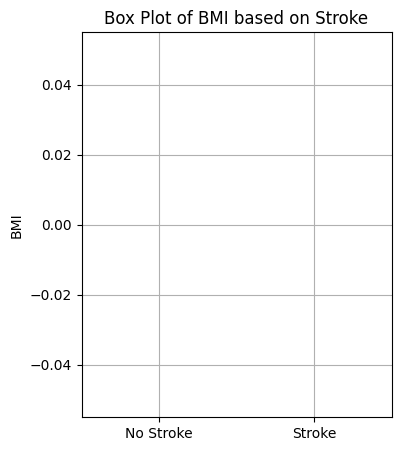

In [26]:
plt.figure(figsize=(4, 5))
plt.boxplot([df[df['stroke'] == 0]['bmi'], df[df['stroke'] == 1]['bmi']], labels=['No Stroke', 'Stroke'])
plt.ylabel('BMI')
plt.title('Box Plot of BMI based on Stroke')
plt.grid(True)
plt.show()

Age versus BMI in both stroke classes:

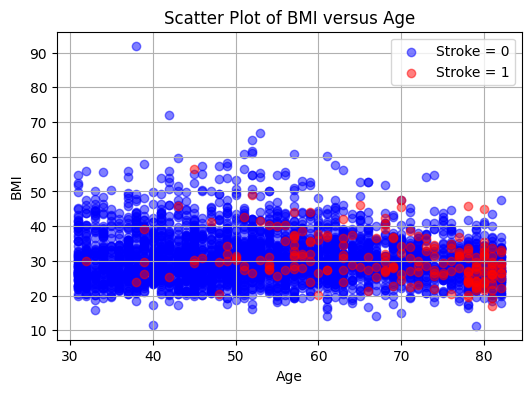

In [27]:
plt.figure(figsize=(6, 4))
plt.scatter(df[df['stroke'] == 0]['age'], df[df['stroke'] == 0]['bmi'], color='blue', alpha=0.5, label='Stroke = 0')
plt.scatter(df[df['stroke'] == 1]['age'], df[df['stroke'] == 1]['bmi'], color='red', alpha=0.5, label='Stroke = 1')
plt.title('Scatter Plot of BMI versus Age')
plt.xlabel('Age')
plt.ylabel('BMI')
plt.grid(True)
plt.legend()
plt.show()

BMI greater than 50 is not realistic for the vast majority of individuals and are clearly outliers in the dataframe.  
We will trim the dataset up to the 50 BMI value.

In [28]:
df = df.drop(df[df['bmi'] > 50].index)

BMI values under 15 when age is > 20 is not realistic as well so we will trim these values. 

In [29]:
rows_to_delete = len(df[(df['bmi'] < 15) & (df['age'] > 30)])
print("Number of rows to be deleted: ", rows_to_delete)
df = df.drop(df[(df['bmi'] < 15) & (df['age'] > 30)].index)

Number of rows to be deleted:  4


### Average Glucose Level

Bimodal data distribution:

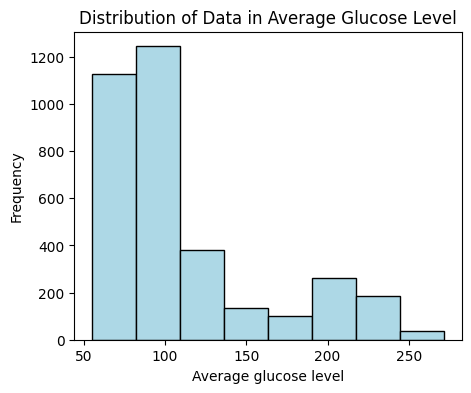

In [30]:
plt.figure(figsize=(5, 4))
plt.hist(df['avg_glucose_level'], bins=8, color='lightblue', edgecolor='black')
plt.title('Distribution of Data in Average Glucose Level')
plt.xlabel('Average glucose level')
plt.ylabel('Frequency')
plt.show()

Average glucose level distribution in both stroke classes:

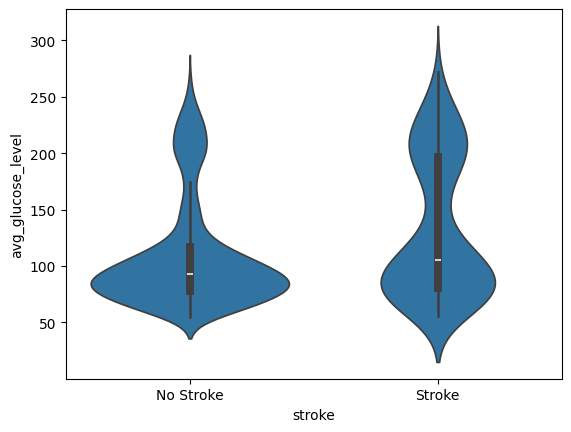

In [31]:
sns.violinplot(x='stroke', y='avg_glucose_level', data=df)
plt.xticks([0, 1], ['No Stroke', 'Stroke'])
plt.show()

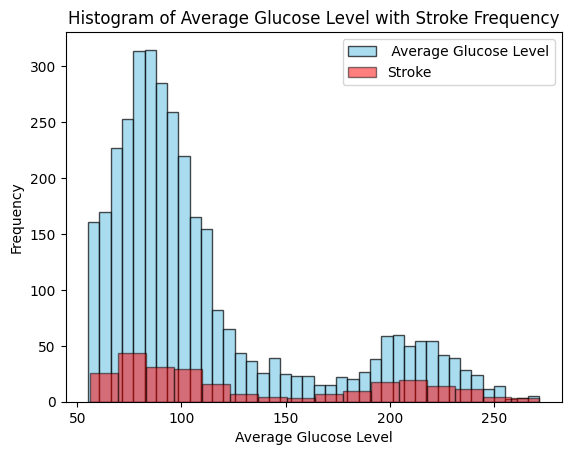

In [32]:
plt.hist(df['avg_glucose_level'], bins=40, color='skyblue', alpha=0.7, edgecolor='black', label=' Average Glucose Level')
plt.hist(df[df['stroke'] == 1]['avg_glucose_level'], bins=16, color='red', alpha=0.5, edgecolor='black', label='Stroke')
plt.xlabel('Average Glucose Level')
plt.ylabel('Frequency')
plt.title('Histogram of Average Glucose Level with Stroke Frequency')
plt.legend()
plt.show()

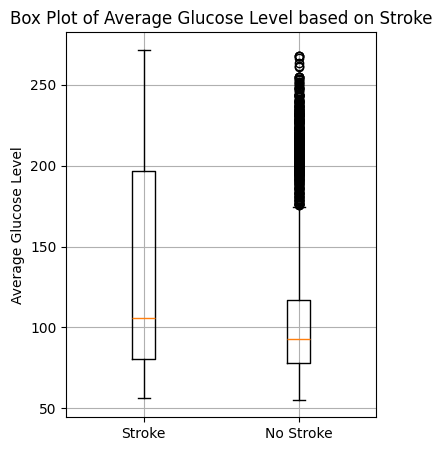

In [33]:
plt.figure(figsize=(4, 5))
plt.boxplot([df[df['stroke'] == 1]['avg_glucose_level'], df[df['stroke'] == 0]['avg_glucose_level']], labels=['Stroke', 'No Stroke'])
plt.ylabel('Average Glucose Level')
plt.title('Box Plot of Average Glucose Level based on Stroke')
plt.grid(True)
plt.show()

**Average Glucose Level might falsely predict the Stroke as it sees all Negative Stroke class as outliers.**

Data of Age versus average glucose level in both stroke classes:

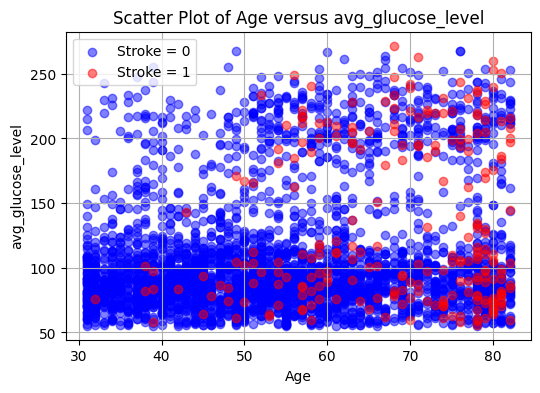

In [34]:
plt.figure(figsize=(6, 4))
plt.scatter(df[df['stroke'] == 0]['age'], df[df['stroke'] == 0]['avg_glucose_level'], color='blue', alpha=0.5, label='Stroke = 0')
plt.scatter(df[df['stroke'] == 1]['age'], df[df['stroke'] == 1]['avg_glucose_level'], color='red', alpha=0.5, label='Stroke = 1')
plt.title('Scatter Plot of Age versus avg_glucose_level')
plt.xlabel('Age')
plt.ylabel('avg_glucose_level')
plt.grid(True)
plt.legend()
plt.show()

In [35]:
import plotly.express as px

fig = px.scatter_3d(df, x='age', y='avg_glucose_level', z='bmi', color='stroke')
fig.show()

### Hypertension (imbalanced)

Data distribution:

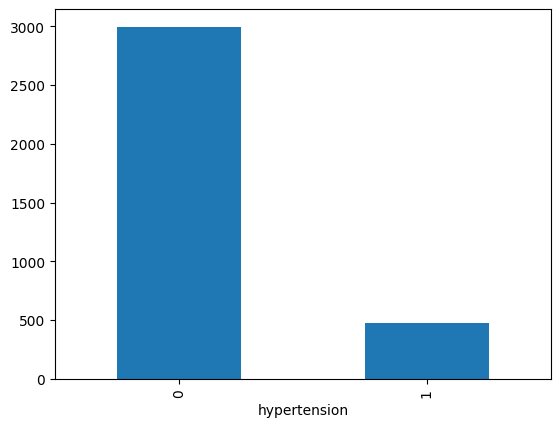

In [36]:
df.hypertension.value_counts().plot(kind='bar')
plt.show()

Data distribution in Positive stroke class:

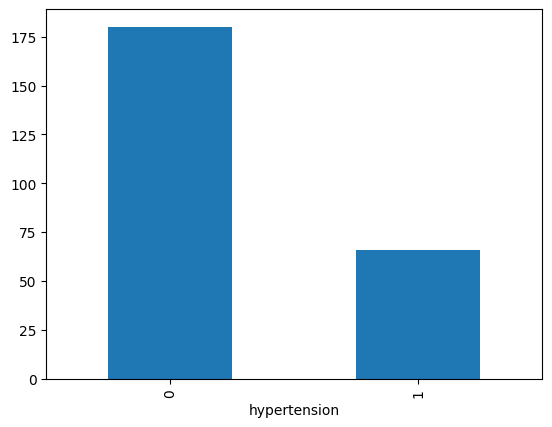

In [37]:
df_stroke = df[df['stroke'] == 1]
df_stroke.hypertension.value_counts().plot(kind='bar')
plt.show()

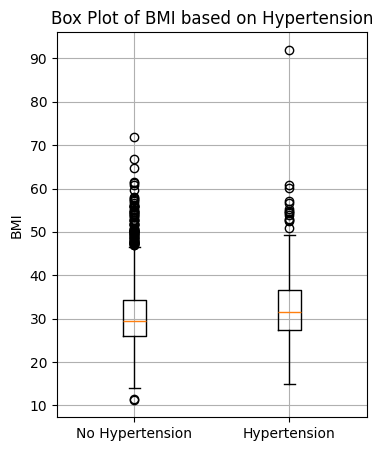

In [38]:
plt.figure(figsize=(4, 5))
plt.boxplot([df_bmi[df_bmi['hypertension'] == 0]['bmi'], df_bmi[df_bmi['hypertension'] == 1]['bmi']], labels=['No Hypertension', 'Hypertension'])
plt.ylabel('BMI')
plt.title('Box Plot of BMI based on Hypertension')
plt.grid(True)
plt.show()

In [39]:
bmi_male = df[df['hypertension'] == 0]['bmi']
bmi_female = df[df['hypertension'] == 1]['bmi']

t_statistic, p_value = ttest_ind(bmi_male, bmi_female)

print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: nan
P-value: nan


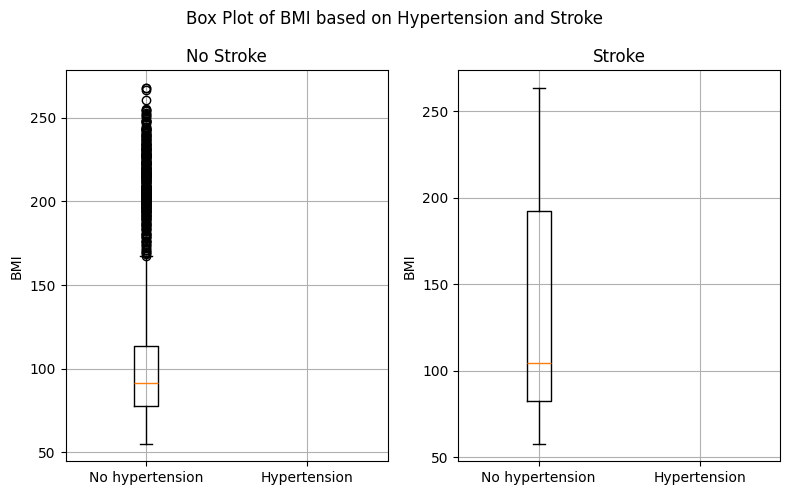

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(8, 5))
axs[0].boxplot([df[(df['hypertension'] == 0) & (df['stroke'] == 0)]['avg_glucose_level'], df[(df['hypertension'] == 1) & (df['stroke'] == 0)]['bmi']])
axs[0].set_title('No Stroke')

axs[1].boxplot([df[(df['hypertension'] == 0) & (df['stroke'] == 1)]['avg_glucose_level'], df[(df['hypertension'] == 1) & (df['stroke'] == 1)]['bmi']])
axs[1].set_title('Stroke')

for ax in axs:
    ax.set_xticklabels(['No hypertension', 'Hypertension'])

for ax in axs:
    ax.set_ylabel('BMI')
    ax.grid(True)

plt.suptitle('Box Plot of BMI based on Hypertension and Stroke')
plt.tight_layout()
plt.show()

In [41]:
bmi_male = df[df['hypertension'] == 0]['avg_glucose_level']
bmi_female = df[df['hypertension'] == 1]['avg_glucose_level']

t_statistic, p_value = ttest_ind(bmi_male, bmi_female)

print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: -9.076384343030613
P-value: 1.8384306686297387e-19


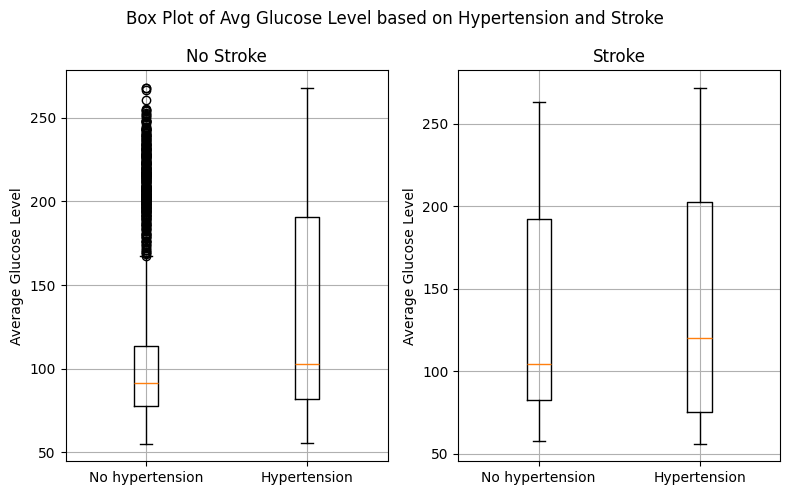

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(8, 5))
axs[0].boxplot([df[(df['hypertension'] == 0) & (df['stroke'] == 0)]['avg_glucose_level'], df[(df['hypertension'] == 1) & (df['stroke'] == 0)]['avg_glucose_level']])
axs[0].set_title('No Stroke')

axs[1].boxplot([df[(df['hypertension'] == 0) & (df['stroke'] == 1)]['avg_glucose_level'], df[(df['hypertension'] == 1) & (df['stroke'] == 1)]['avg_glucose_level']])
axs[1].set_title('Stroke')

for ax in axs:
    ax.set_xticklabels(['No hypertension', 'Hypertension'])

for ax in axs:
    ax.set_ylabel('Average Glucose Level')
    ax.grid(True)

plt.suptitle('Box Plot of Avg Glucose Level based on Hypertension and Stroke')
plt.tight_layout()
plt.show()

### Heart Disease (imbalanced)

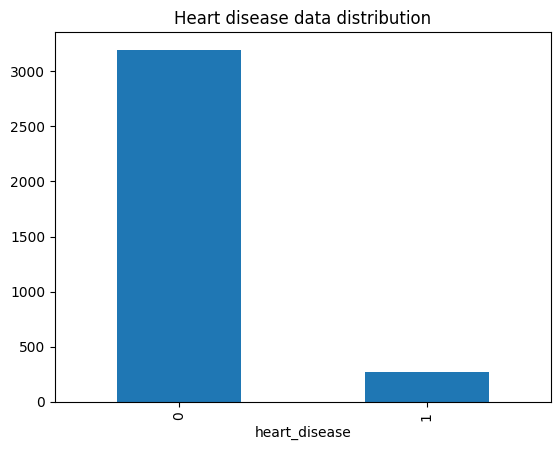

In [43]:
df.heart_disease.value_counts().plot(kind='bar')
plt.title('Heart disease data distribution')
plt.show()

heart_disease
0    199
1     47
Name: count, dtype: int64


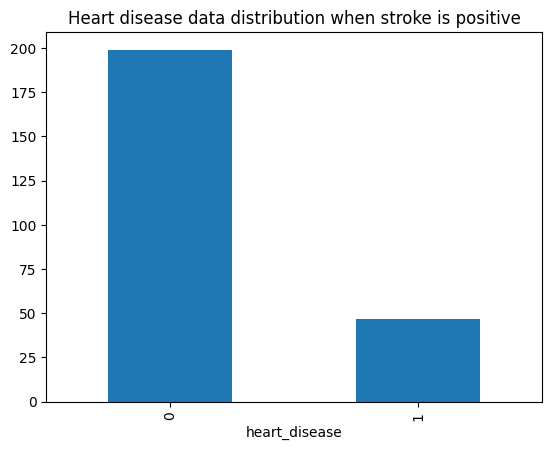

In [44]:
df_stroke = df[df['stroke'] == 1]
print(df_stroke.heart_disease.value_counts())
df_stroke.heart_disease.value_counts().plot(kind='bar')
plt.title('Heart disease data distribution when stroke is positive')
plt.show()

In [45]:
avg_glucose_level_male = df[df['heart_disease'] == 0]['avg_glucose_level']
avg_glucose_level_female = df[df['heart_disease'] == 1]['avg_glucose_level']

t_statistic, p_value = ttest_ind(avg_glucose_level_male, avg_glucose_level_female)

print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: -9.184995329002751
P-value: 6.901545241745105e-20


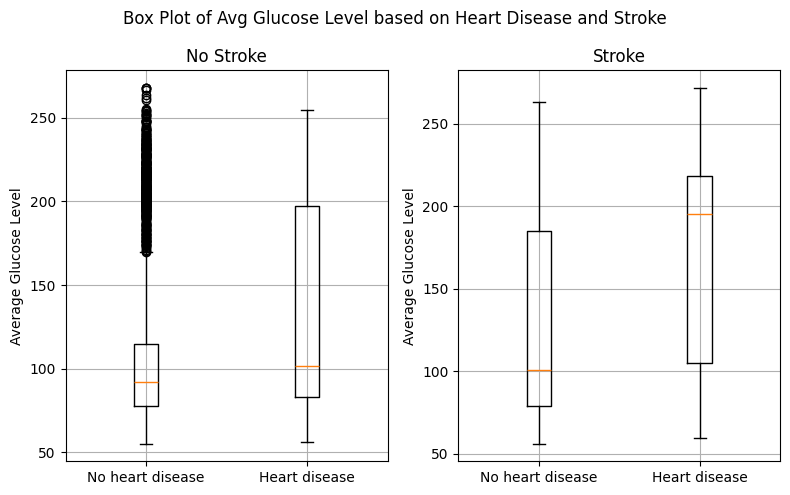

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(8, 5))
axs[0].boxplot([df[(df['heart_disease'] == 0) & (df['stroke'] == 0)]['avg_glucose_level'], df[(df['heart_disease'] == 1) & (df['stroke'] == 0)]['avg_glucose_level']])
axs[0].set_title('No Stroke')

axs[1].boxplot([df[(df['heart_disease'] == 0) & (df['stroke'] == 1)]['avg_glucose_level'], df[(df['heart_disease'] == 1) & (df['stroke'] == 1)]['avg_glucose_level']])
axs[1].set_title('Stroke')

for ax in axs:
    ax.set_xticklabels(['No heart disease', 'Heart disease'])

for ax in axs:
    ax.set_ylabel('Average Glucose Level')
    ax.grid(True)

plt.suptitle('Box Plot of Avg Glucose Level based on Heart Disease and Stroke')
plt.tight_layout()
plt.show()

In [47]:
bmi_male = df[df['heart_disease'] == 0]['bmi']
bmi_female = df[df['heart_disease'] == 1]['bmi']

t_statistic, p_value = ttest_ind(bmi_male, bmi_female)

print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: nan
P-value: nan


In [48]:
age_male = df[df['heart_disease'] == 0]['age']
age_female = df[df['heart_disease'] == 1]['age']

t_statistic, p_value = ttest_ind(age_male, age_female)

print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: -15.884269283669674
P-value: 6.728877878320228e-55


### Ever Married

There is significant correlation between ever_married and age: **68%**

In [49]:
continuous_var = 'age'

binary_var = 'ever_married'

print(f'Point-biserial correlation coefficients for {continuous_var}:')
correlation_coefficient, p_value = pointbiserialr(df[continuous_var], df[binary_var])
print(f'{binary_var}: {correlation_coefficient:.4f} (p-value: {p_value:.4f})')

Point-biserial correlation coefficients for age:
ever_married: 0.1265 (p-value: 0.0000)


Since the two variables - age and ever_married are highly associated, we will delete the ever_married column from the dataframe.

In [50]:
df = df.drop('ever_married', axis=1)

### Work Type (imbalanced)

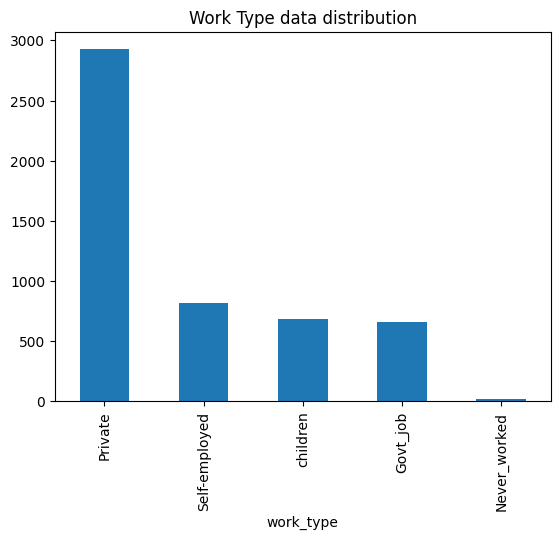

In [51]:
df_original.work_type.value_counts().plot(kind='bar')
plt.title('Work Type data distribution')
plt.show()

**Chi-squared test of the relationthip between work type and stroke**

### Residence Type

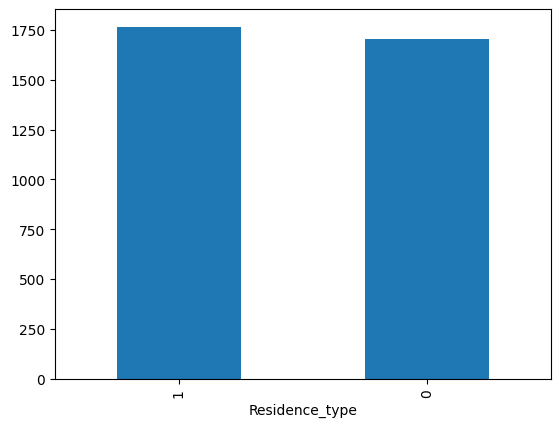

In [52]:
df.Residence_type.value_counts().plot(kind='bar')
plt.show()

### Smoking Status  
**There are 1460 records where smoking_status is Unknown**

Original data:

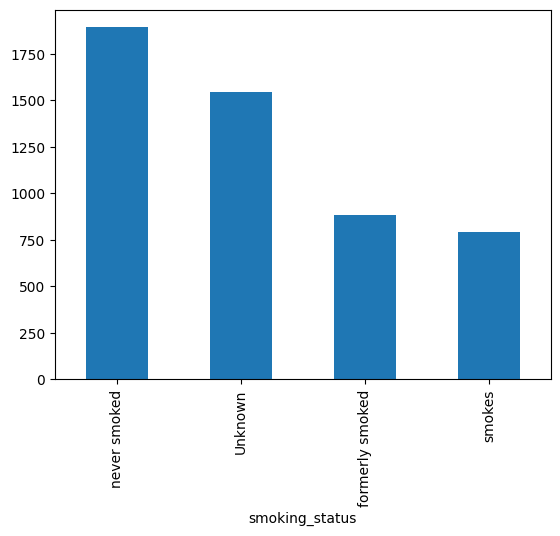

In [53]:
df_original.smoking_status.value_counts().plot(kind='bar')
plt.show()

Initially cleaned dataframe data where nominal textual variables are converted to numerical:

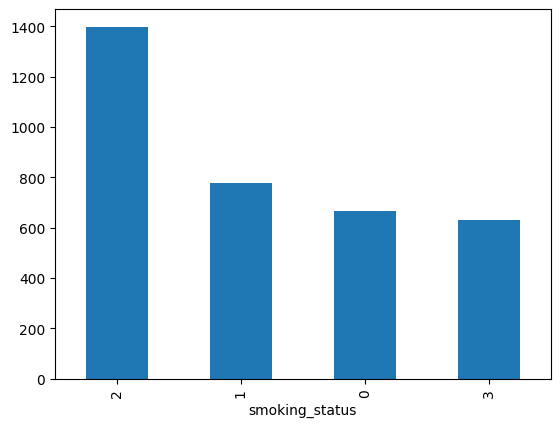

In [54]:
df.smoking_status.value_counts().plot(kind='bar')
plt.show()

Calculating Null smoking_status values:

In [55]:
df_smoking_unknown = df[df['smoking_status']==0]
print(len(df_smoking_unknown))

665


**There are 1460 records where smoking_status is Unknown**

In [56]:
df_smoking_unknown = df[(df['smoking_status']==0) & (df['stroke']==0)]
print(len(df_smoking_unknown))

620


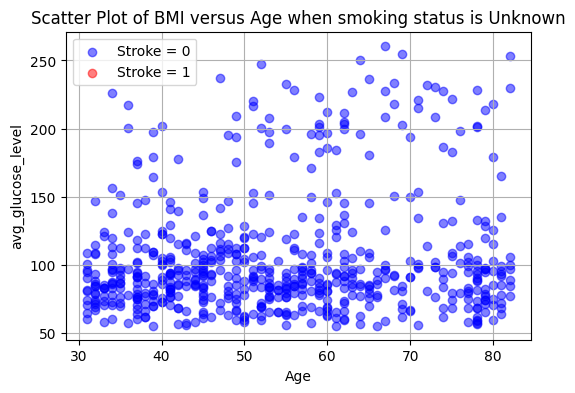

In [57]:
plt.figure(figsize=(6, 4))
plt.scatter(df_smoking_unknown[df_smoking_unknown['stroke'] == 0]['age'], df_smoking_unknown[df_smoking_unknown['stroke'] == 0]['avg_glucose_level'], color='blue', alpha=0.5, label='Stroke = 0')
plt.scatter(df_smoking_unknown[df_smoking_unknown['stroke'] == 1]['age'], df_smoking_unknown[df_smoking_unknown['stroke'] == 1]['avg_glucose_level'], color='red', alpha=0.5, label='Stroke = 1')
plt.title('Scatter Plot of BMI versus Age when smoking status is Unknown')
plt.xlabel('Age')
plt.ylabel('avg_glucose_level')
plt.grid(True)
plt.legend()
plt.show()

**There are many records where smoking_status is Unknown and stroke is Negative**

In [58]:
df = df.drop(df[(df['smoking_status'] == 0) & (df['stroke'] == 0)].index)

### Dealing with missing values

Grouping the values of continuous variables (*age*, *average glucose level* and *bmi*) **based on histograms with minimum logical number of bins** for records grouping and finding missing BMI values.

Working with **df_grouped_cont_v** from here.

In [59]:
df_grouped_cont_v = df.copy()

##### Age

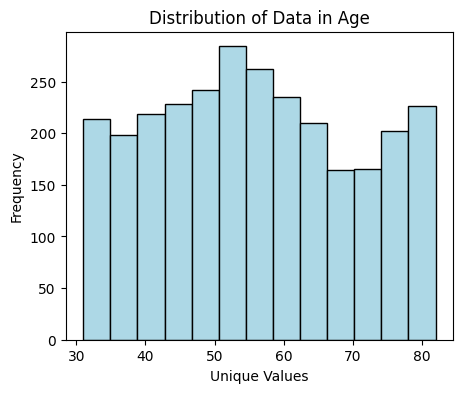

In [60]:
plt.figure(figsize=(5, 4))
plt.hist(df_grouped_cont_v['age'], bins=13, color='lightblue', edgecolor='black')
plt.title('Distribution of Data in Age')
plt.xlabel('Unique Values')
plt.ylabel('Frequency')
plt.show()

In [61]:
hist_values, _ = np.histogram(df_grouped_cont_v['age'], bins=13, range=(df_grouped_cont_v['age'].min(), df_grouped_cont_v['age'].max()))
df_grouped_cont_v['age_histogram'] = np.digitize(df_grouped_cont_v['age'], bins=np.arange(df_grouped_cont_v['age'].min(), df_grouped_cont_v['age'].max(), (df_grouped_cont_v['age'].max()-df_grouped_cont_v['age'].min())/13))
df_grouped_cont_v

id  gender   age  hypertension  heart_disease  work_type  \
0      9046       1  67.0             0              1          2   
1     51676       0  61.0             0              0          3   
2     31112       1  80.0             0              1          2   
3     60182       0  49.0             0              0          2   
4      1665       0  79.0             1              0          3   
...     ...     ...   ...           ...            ...        ...   
5102  45010       0  57.0             0              0          2   
5105  18234       0  80.0             1              0          2   
5106  44873       0  81.0             0              0          3   
5107  19723       0  35.0             0              0          3   
5108  37544       1  51.0             0              0          2   

      Residence_type  avg_glucose_level   bmi  smoking_status  stroke  \
0                  1             228.69  36.6               1       1   
1                  0             202.21   NaN               2       1   
2                  0             105.92  32.5               2       1   
3                  1             171.23  34.4               3       1   
4                  0             174.12  24.0               2       1   
...              ...                ...   ...             ...     ...   
5102               0              77.93  21.7               2       0   
5105               1              83.75   NaN               2       0   
5106               1             125.20  40.0               2       0   
5107               0              82.99  30.6               2       0   
5108               0             166.29  25.6               1       0   

      age_histogram  
0                10  
1                 8  
2                13  
3                 5  
4                13  
...             ...  
5102              7  
5105             13  
5106             13  
5107              2  
5108              6  

[2849 rows x 12 columns]

##### Average glucose level

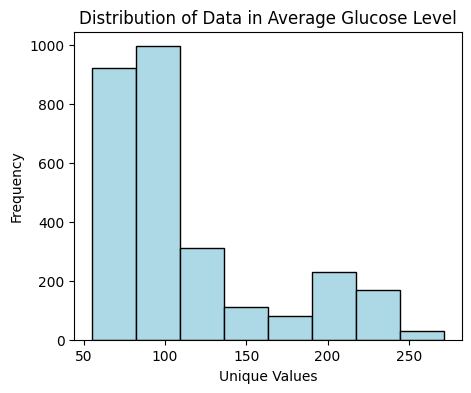

In [62]:
plt.figure(figsize=(5, 4))
plt.hist(df_grouped_cont_v['avg_glucose_level'], bins=8, color='lightblue', edgecolor='black')
plt.title('Distribution of Data in Average Glucose Level')
plt.xlabel('Unique Values')
plt.ylabel('Frequency')
plt.show()

In [63]:
hist_values, _ = np.histogram(df_grouped_cont_v['avg_glucose_level'], bins=8, range=(df_grouped_cont_v['avg_glucose_level'].min(), df_grouped_cont_v['avg_glucose_level'].max()))
df_grouped_cont_v['avg_glucose_level_histogram'] = np.digitize(df_grouped_cont_v['avg_glucose_level'], bins=np.arange(df_grouped_cont_v['avg_glucose_level'].min(), df_grouped_cont_v['avg_glucose_level'].max(), (df_grouped_cont_v['avg_glucose_level'].max()-df_grouped_cont_v['avg_glucose_level'].min())/8))
df_grouped_cont_v

id  gender   age  hypertension  heart_disease  work_type  \
0      9046       1  67.0             0              1          2   
1     51676       0  61.0             0              0          3   
2     31112       1  80.0             0              1          2   
3     60182       0  49.0             0              0          2   
4      1665       0  79.0             1              0          3   
...     ...     ...   ...           ...            ...        ...   
5102  45010       0  57.0             0              0          2   
5105  18234       0  80.0             1              0          2   
5106  44873       0  81.0             0              0          3   
5107  19723       0  35.0             0              0          3   
5108  37544       1  51.0             0              0          2   

      Residence_type  avg_glucose_level   bmi  smoking_status  stroke  \
0                  1             228.69  36.6               1       1   
1                  0             202.21   NaN               2       1   
2                  0             105.92  32.5               2       1   
3                  1             171.23  34.4               3       1   
4                  0             174.12  24.0               2       1   
...              ...                ...   ...             ...     ...   
5102               0              77.93  21.7               2       0   
5105               1              83.75   NaN               2       0   
5106               1             125.20  40.0               2       0   
5107               0              82.99  30.6               2       0   
5108               0             166.29  25.6               1       0   

      age_histogram  avg_glucose_level_histogram  
0                10                            7  
1                 8                            6  
2                13                            2  
3                 5                            5  
4                13                            5  
...             ...                          ...  
5102              7                            1  
5105             13                            2  
5106             13                            3  
5107              2                            2  
5108              6                            5  

[2849 rows x 13 columns]

##### BMI

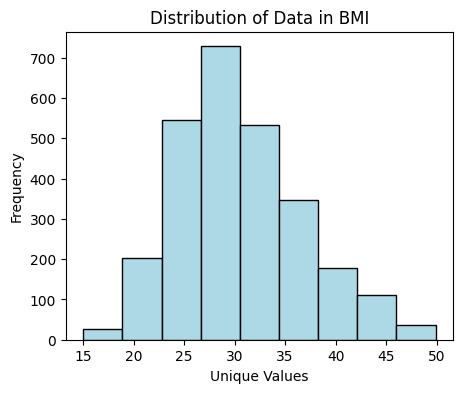

In [64]:
plt.figure(figsize=(5, 4))
plt.hist(df_grouped_cont_v['bmi'], bins=9, color='lightblue', edgecolor='black')
plt.title('Distribution of Data in BMI')
plt.xlabel('Unique Values')
plt.ylabel('Frequency')
plt.show()

In [65]:
hist_values, _ = np.histogram(df_grouped_cont_v['bmi'], bins=9, range=(df_grouped_cont_v['bmi'].min(), df_grouped_cont_v['bmi'].max()))
df_grouped_cont_v['bmi_histogram'] = np.digitize(df_grouped_cont_v['bmi'], bins=np.arange(df_grouped_cont_v['bmi'].min(), df_grouped_cont_v['bmi'].max(), (df_grouped_cont_v['bmi'].max()-df_grouped_cont_v['bmi'].min())/9))
df_grouped_cont_v

id  gender   age  hypertension  heart_disease  work_type  \
0      9046       1  67.0             0              1          2   
1     51676       0  61.0             0              0          3   
2     31112       1  80.0             0              1          2   
3     60182       0  49.0             0              0          2   
4      1665       0  79.0             1              0          3   
...     ...     ...   ...           ...            ...        ...   
5102  45010       0  57.0             0              0          2   
5105  18234       0  80.0             1              0          2   
5106  44873       0  81.0             0              0          3   
5107  19723       0  35.0             0              0          3   
5108  37544       1  51.0             0              0          2   

      Residence_type  avg_glucose_level   bmi  smoking_status  stroke  \
0                  1             228.69  36.6               1       1   
1                  0             202.21   NaN               2       1   
2                  0             105.92  32.5               2       1   
3                  1             171.23  34.4               3       1   
4                  0             174.12  24.0               2       1   
...              ...                ...   ...             ...     ...   
5102               0              77.93  21.7               2       0   
5105               1              83.75   NaN               2       0   
5106               1             125.20  40.0               2       0   
5107               0              82.99  30.6               2       0   
5108               0             166.29  25.6               1       0   

      age_histogram  avg_glucose_level_histogram  bmi_histogram  
0                10                            7              6  
1                 8                            6              9  
2                13                            2              5  
3                 5                            5              6  
4                13                            5              3  
...             ...                          ...            ...  
5102              7                            1              2  
5105             13                            2              9  
5106             13                            3              7  
5107              2                            2              5  
5108              6                            5              3  

[2849 rows x 14 columns]

##### Imputing missing BMI values

df_grouped_cont_v with 195 empty BMI values:

In [66]:
df_bmi_unknown = df[df['bmi'].isnull()]
print('Records in the df where bmi is unknown before imputation:', len(df_bmi_unknown))

Records in the df where bmi is unknown before imputation: 140


Grouping the df_grouped_cont_v data by all categorical parameters and continuous variables grouped to numerical histogram bin numbers:

In [67]:
grouped_data = df_grouped_cont_v.groupby(['gender', 'hypertension', 'heart_disease', 'work_type', 'Residence_type', 'smoking_status', 'stroke', 'age_histogram', 'avg_glucose_level_histogram'])

df_bmi_unknown = df_grouped_cont_v[df_grouped_cont_v['bmi'].isnull()]
# Extract id values of records with unknown BMI
unknown_bmi_ids = df_bmi_unknown['id'].tolist()
df_bmi_unknown.sort_values(by='age', ascending=False)

id  gender   age  hypertension  heart_disease  work_type  \
4164  40163       0  82.0             1              0          2   
5105  18234       0  80.0             1              0          2   
178   33486       0  80.0             0              0          0   
2541  61252       1  79.0             0              1          2   
150   11933       0  79.0             0              0          2   
...     ...     ...   ...           ...            ...        ...   
1779  18861       1  32.0             0              0          2   
4069  12693       1  31.0             0              0          2   
4984   1503       1  31.0             0              0          2   
680   29873       1  31.0             1              0          0   
3214   1213       0  31.0             0              0          3   

      Residence_type  avg_glucose_level  bmi  smoking_status  stroke  \
4164               1             222.52  NaN               1       0   
5105               1              83.75  NaN               2       0   
178                1             110.66  NaN               0       1   
2541               0              82.27  NaN               2       0   
150                0             169.67  NaN               0       1   
...              ...                ...  ...             ...     ...   
1779               0              95.58  NaN               3       0   
4069               1             108.62  NaN               3       0   
4984               1             215.07  NaN               3       0   
680                1              92.11  NaN               2       0   
3214               1              87.23  NaN               1       0   

      age_histogram  avg_glucose_level_histogram  bmi_histogram  
4164             13                            7              9  
5105             13                            2              9  
178              13                            3              9  
2541             13                            1              9  
150              13                            5              9  
...             ...                          ...            ...  
1779              1                            2              9  
4069              1                            2              9  
4984              1                            6              9  
680               1                            2              9  
3214              1                            2              9  

[140 rows x 14 columns]

Calculating the average BMI value for each group and filling missing values in the group with the group average:

In [68]:
for group_name, group_data in grouped_data:
    nan_bmi_indices = group_data[group_data['bmi'].isnull()].index
    if nan_bmi_indices.any():
        group_average_bmi = group_data['bmi'].mean()
        group_average_bmi = round(group_average_bmi, 2)
        df_grouped_cont_v.loc[nan_bmi_indices, 'bmi'] = group_average_bmi

In [69]:
filtered_df = df_grouped_cont_v[df_grouped_cont_v['id'].isin(unknown_bmi_ids)]
filtered_df.sort_values(by='age', ascending=False)

id  gender   age  hypertension  heart_disease  work_type  \
4164  40163       0  82.0             1              0          2   
5105  18234       0  80.0             1              0          2   
178   33486       0  80.0             0              0          0   
2541  61252       1  79.0             0              1          2   
150   11933       0  79.0             0              0          2   
...     ...     ...   ...           ...            ...        ...   
1779  18861       1  32.0             0              0          2   
4069  12693       1  31.0             0              0          2   
4984   1503       1  31.0             0              0          2   
680   29873       1  31.0             1              0          0   
3214   1213       0  31.0             0              0          3   

      Residence_type  avg_glucose_level    bmi  smoking_status  stroke  \
4164               1             222.52    NaN               1       0   
5105               1              83.75  25.00               2       0   
178                1             110.66    NaN               0       1   
2541               0              82.27    NaN               2       0   
150                0             169.67    NaN               0       1   
...              ...                ...    ...             ...     ...   
1779               0              95.58  29.07               3       0   
4069               1             108.62  31.47               3       0   
4984               1             215.07    NaN               3       0   
680                1              92.11    NaN               2       0   
3214               1              87.23    NaN               1       0   

      age_histogram  avg_glucose_level_histogram  bmi_histogram  
4164             13                            7              9  
5105             13                            2              9  
178              13                            3              9  
2541             13                            1              9  
150              13                            5              9  
...             ...                          ...            ...  
1779              1                            2              9  
4069              1                            2              9  
4984              1                            6              9  
680               1                            2              9  
3214              1                            2              9  

[140 rows x 14 columns]

In [70]:
# Iterate over the unknown BMI IDs and update corresponding records in df
for idx in unknown_bmi_ids:
    bmi_value = df_grouped_cont_v.loc[df_grouped_cont_v['id'] == idx, 'bmi'].iloc[0]
    df.loc[df['id'] == idx, 'bmi'] = bmi_value

In [71]:
df_bmi_unknown = df[df['bmi'].isnull()]
print('Records in the df where bmi is unknown after imputation:', len(df_bmi_unknown))

Records in the df where bmi is unknown after imputation: 102


###### Another round of imputation with larger groups

In [72]:
df_bmi_unknown = df_grouped_cont_v[df_grouped_cont_v['bmi'].isnull()]
# Extract id values of records with unknown BMI
unknown_bmi_ids = df_bmi_unknown['id'].tolist()

In [73]:
grouped_data = df_grouped_cont_v.groupby(['hypertension', 'heart_disease', 'work_type', 'smoking_status', 'age_histogram', 'avg_glucose_level_histogram'])

for group_name, group_data in grouped_data:
    nan_bmi_indices = group_data[group_data['bmi'].isnull()].index
    if nan_bmi_indices.any():
        group_average_bmi = group_data['bmi'].mean()
        group_average_bmi = round(group_average_bmi, 2)
        df_grouped_cont_v.loc[nan_bmi_indices, 'bmi'] = group_average_bmi

In [74]:
# Iterate over the unknown BMI IDs and update corresponding records in df
for idx in unknown_bmi_ids:
    bmi_value = df_grouped_cont_v.loc[df_grouped_cont_v['id'] == idx, 'bmi'].iloc[0]
    df.loc[df['id'] == idx, 'bmi'] = bmi_value

In [75]:
df_bmi_unknown = df[df['bmi'].isnull()]
print('Records in the df where bmi is unknown after imputation:', len(df_bmi_unknown))

Records in the df where bmi is unknown after imputation: 61


###### Another round of imputation with larger groups

In [76]:
df_bmi_unknown = df_grouped_cont_v[df_grouped_cont_v['bmi'].isnull()]
# Extract id values of records with unknown BMI
unknown_bmi_ids = df_bmi_unknown['id'].tolist()

In [77]:
grouped_data = df_grouped_cont_v.groupby(['hypertension', 'work_type', 'smoking_status', 'age_histogram', 'avg_glucose_level_histogram'])

for group_name, group_data in grouped_data:
    nan_bmi_indices = group_data[group_data['bmi'].isnull()].index
    if nan_bmi_indices.any():
        group_average_bmi = group_data['bmi'].mean()
        group_average_bmi = round(group_average_bmi, 2)
        df_grouped_cont_v.loc[nan_bmi_indices, 'bmi'] = group_average_bmi

In [78]:
# Iterate over the unknown BMI IDs and update corresponding records in df
for idx in unknown_bmi_ids:
    bmi_value = df_grouped_cont_v.loc[df_grouped_cont_v['id'] == idx, 'bmi'].iloc[0]
    df.loc[df['id'] == idx, 'bmi'] = bmi_value

In [79]:
df_bmi_unknown = df[df['bmi'].isnull()]
print('Records in the df where bmi is unknown after imputation:', len(df_bmi_unknown))

Records in the df where bmi is unknown after imputation: 46


###### Another round of imputation with larger groups

In [80]:
df_bmi_unknown = df_grouped_cont_v[df_grouped_cont_v['bmi'].isnull()]
# Extract id values of records with unknown BMI
unknown_bmi_ids = df_bmi_unknown['id'].tolist()

In [81]:
grouped_data = df_grouped_cont_v.groupby(['work_type', 'smoking_status', 'age_histogram', 'avg_glucose_level_histogram'])

for group_name, group_data in grouped_data:
    nan_bmi_indices = group_data[group_data['bmi'].isnull()].index
    if nan_bmi_indices.any():
        group_average_bmi = group_data['bmi'].mean()
        group_average_bmi = round(group_average_bmi, 2)
        df_grouped_cont_v.loc[nan_bmi_indices, 'bmi'] = group_average_bmi

In [82]:
# Iterate over the unknown BMI IDs and update corresponding records in df
for idx in unknown_bmi_ids:
    bmi_value = df_grouped_cont_v.loc[df_grouped_cont_v['id'] == idx, 'bmi'].iloc[0]
    df.loc[df['id'] == idx, 'bmi'] = bmi_value

In [83]:
df_bmi_unknown = df[df['bmi'].isnull()]
print('Records in the df where bmi is unknown after imputation:', len(df_bmi_unknown))

Records in the df where bmi is unknown after imputation: 29


###### Another round of imputation with larger groups

In [84]:
df_bmi_unknown = df_grouped_cont_v[df_grouped_cont_v['bmi'].isnull()]
# Extract id values of records with unknown BMI
unknown_bmi_ids = df_bmi_unknown['id'].tolist()

In [85]:
grouped_data = df_grouped_cont_v.groupby(['work_type', 'age_histogram', 'avg_glucose_level_histogram'])

for group_name, group_data in grouped_data:
    nan_bmi_indices = group_data[group_data['bmi'].isnull()].index
    if nan_bmi_indices.any():
        group_average_bmi = group_data['bmi'].mean()
        group_average_bmi = round(group_average_bmi, 2)
        df_grouped_cont_v.loc[nan_bmi_indices, 'bmi'] = group_average_bmi

In [86]:
# Iterate over the unknown BMI IDs and update corresponding records in df
for idx in unknown_bmi_ids:
    bmi_value = df_grouped_cont_v.loc[df_grouped_cont_v['id'] == idx, 'bmi'].iloc[0]
    df.loc[df['id'] == idx, 'bmi'] = bmi_value

In [87]:
df_bmi_unknown = df[df['bmi'].isnull()]
print('Records in the df where bmi is unknown after imputation:', len(df_bmi_unknown))

Records in the df where bmi is unknown after imputation: 1


In [88]:
df_bmi_unknown = df[df['bmi'].isnull()]
df_bmi_unknown

id  gender   age  hypertension  heart_disease  work_type  \
1718  2513       1  59.0             0              1          0   

      Residence_type  avg_glucose_level  bmi  smoking_status  stroke  
1718               1             188.69  NaN               1       0

In [89]:
df = df.drop(df[(df['bmi'].isnull())].index)

##### Imputing missing Smoking Status values

Imputing missing Smoking Status values to df_smoking_status_imputed

In [90]:
df_smoking_status_imputed = df.copy()

In [91]:
df_smoking_status_imputed['smoking_status'] = np.where(df_smoking_status_imputed['smoking_status'] == 0, np.nan, df_smoking_status_imputed['smoking_status'])
df_ss_unknown = df_smoking_status_imputed[df_smoking_status_imputed['smoking_status'].isnull()]
print('Records in the df where smoking_status is unknown before imputation:', len(df_ss_unknown))
print()

Records in the df where smoking_status is unknown before imputation: 45



In [92]:
grouped_data = df_grouped_cont_v.groupby(['gender', 'hypertension', 'heart_disease', 'work_type', 'Residence_type', 'stroke', 'age_histogram', 'avg_glucose_level_histogram'])

df_ss_unknown = df_grouped_cont_v[df_grouped_cont_v['smoking_status'].isnull()]
unknown_ss_ids = df_ss_unknown['id'].tolist()

for group_name, group_data in grouped_data:
    nan_ss_indices = group_data[group_data['smoking_status'].isnull()].index
    if nan_ss_indices.any():
        try:
            group_mode_ss = group_data['smoking_status'].mode().iloc[0]
            df_grouped_cont_v.loc[nan_ss_indices, 'smoking_status'] = group_mode_ss
        except: pass

for idx in unknown_ss_ids:
    ss_value = df_grouped_cont_v.loc[df_grouped_cont_v['id'] == idx, 'smoking_status'].iloc[0]
    df_smoking_status_imputed.loc[df_smoking_status_imputed['id'] == idx, 'smoking_status'] = ss_value

df_ss_unknown = df_smoking_status_imputed[df_smoking_status_imputed['smoking_status'].isnull()]
print('Records in the df where smoking_status is unknown after imputation:', len(df_ss_unknown))

Records in the df where smoking_status is unknown after imputation: 45


Another round with larger groups

In [93]:
grouped_data = df_grouped_cont_v.groupby(['gender', 'hypertension', 'heart_disease', 'work_type', 'stroke', 'age_histogram', 'avg_glucose_level_histogram'])

df_ss_unknown = df_grouped_cont_v[df_grouped_cont_v['smoking_status'].isnull()]
unknown_ss_ids = df_ss_unknown['id'].tolist()

for group_name, group_data in grouped_data:
    nan_ss_indices = group_data[group_data['smoking_status'].isnull()].index
    if nan_ss_indices.any():
        try:
            group_mode_ss = group_data['smoking_status'].mode().iloc[0]
            df_grouped_cont_v.loc[nan_ss_indices, 'smoking_status'] = group_mode_ss
        except: pass

for idx in unknown_ss_ids:
    ss_value = df_grouped_cont_v.loc[df_grouped_cont_v['id'] == idx, 'smoking_status'].iloc[0]
    df_smoking_status_imputed.loc[df_smoking_status_imputed['id'] == idx, 'smoking_status'] = ss_value

df_ss_unknown = df_smoking_status_imputed[df_smoking_status_imputed['smoking_status'].isnull()]
print('Records in the df where smoking_status is unknown after imputation:', len(df_ss_unknown))

Records in the df where smoking_status is unknown after imputation: 45


Another round with larger groups

In [94]:
grouped_data = df_grouped_cont_v.groupby(['gender', 'hypertension', 'heart_disease', 'stroke', 'age_histogram', 'avg_glucose_level_histogram'])

df_ss_unknown = df_grouped_cont_v[df_grouped_cont_v['smoking_status'].isnull()]
unknown_ss_ids = df_ss_unknown['id'].tolist()

for group_name, group_data in grouped_data:
    nan_ss_indices = group_data[group_data['smoking_status'].isnull()].index
    if nan_ss_indices.any():
        try:
            group_mode_ss = group_data['smoking_status'].mode().iloc[0]
            df_grouped_cont_v.loc[nan_ss_indices, 'smoking_status'] = group_mode_ss
        except: pass

for idx in unknown_ss_ids:
    ss_value = df_grouped_cont_v.loc[df_grouped_cont_v['id'] == idx, 'smoking_status'].iloc[0]
    df_smoking_status_imputed.loc[df_smoking_status_imputed['id'] == idx, 'smoking_status'] = ss_value

df_ss_unknown = df_smoking_status_imputed[df_smoking_status_imputed['smoking_status'].isnull()]
print('Records in the df where smoking_status is unknown after imputation:', len(df_ss_unknown))

Records in the df where smoking_status is unknown after imputation: 45


In [95]:
grouped_data = df_grouped_cont_v.groupby(['gender', 'hypertension', 'stroke', 'age_histogram', 'avg_glucose_level_histogram'])

df_ss_unknown = df_grouped_cont_v[df_grouped_cont_v['smoking_status'].isnull()]
unknown_ss_ids = df_ss_unknown['id'].tolist()

for group_name, group_data in grouped_data:
    nan_ss_indices = group_data[group_data['smoking_status'].isnull()].index
    if nan_ss_indices.any():
        try:
            group_mode_ss = group_data['smoking_status'].mode().iloc[0]
            df_grouped_cont_v.loc[nan_ss_indices, 'smoking_status'] = group_mode_ss
        except: pass

for idx in unknown_ss_ids:
    ss_value = df_grouped_cont_v.loc[df_grouped_cont_v['id'] == idx, 'smoking_status'].iloc[0]
    df_smoking_status_imputed.loc[df_smoking_status_imputed['id'] == idx, 'smoking_status'] = ss_value

df_ss_unknown = df_smoking_status_imputed[df_smoking_status_imputed['smoking_status'].isnull()]
print('Records in the df where smoking_status is unknown after imputation:', len(df_ss_unknown))

Records in the df where smoking_status is unknown after imputation: 45


In [96]:
grouped_data = df_grouped_cont_v.groupby(['gender', 'stroke', 'age_histogram', 'avg_glucose_level_histogram'])

df_ss_unknown = df_grouped_cont_v[df_grouped_cont_v['smoking_status'].isnull()]
unknown_ss_ids = df_ss_unknown['id'].tolist()

for group_name, group_data in grouped_data:
    nan_ss_indices = group_data[group_data['smoking_status'].isnull()].index
    if nan_ss_indices.any():
        try:
            group_mode_ss = group_data['smoking_status'].mode().iloc[0]
            df_grouped_cont_v.loc[nan_ss_indices, 'smoking_status'] = group_mode_ss
        except: pass

for idx in unknown_ss_ids:
    ss_value = df_grouped_cont_v.loc[df_grouped_cont_v['id'] == idx, 'smoking_status'].iloc[0]
    df_smoking_status_imputed.loc[df_smoking_status_imputed['id'] == idx, 'smoking_status'] = ss_value

df_ss_unknown = df_smoking_status_imputed[df_smoking_status_imputed['smoking_status'].isnull()]
print('Records in the df where smoking_status is unknown after imputation:', len(df_ss_unknown))

Records in the df where smoking_status is unknown after imputation: 45


In [97]:
grouped_data = df_grouped_cont_v.groupby(['stroke', 'age_histogram', 'avg_glucose_level_histogram'])

df_ss_unknown = df_grouped_cont_v[df_grouped_cont_v['smoking_status'].isnull()]
unknown_ss_ids = df_ss_unknown['id'].tolist()

for group_name, group_data in grouped_data:
    nan_ss_indices = group_data[group_data['smoking_status'].isnull()].index
    if nan_ss_indices.any():
        try:
            group_mode_ss = group_data['smoking_status'].mode().iloc[0]
            df_grouped_cont_v.loc[nan_ss_indices, 'smoking_status'] = group_mode_ss
        except: pass

for idx in unknown_ss_ids:
    ss_value = df_grouped_cont_v.loc[df_grouped_cont_v['id'] == idx, 'smoking_status'].iloc[0]
    df_smoking_status_imputed.loc[df_smoking_status_imputed['id'] == idx, 'smoking_status'] = ss_value

df_ss_unknown = df_smoking_status_imputed[df_smoking_status_imputed['smoking_status'].isnull()]
print('Records in the df where smoking_status is unknown after imputation:', len(df_ss_unknown))

Records in the df where smoking_status is unknown after imputation: 45


In [98]:
grouped_data = df_grouped_cont_v.groupby(['stroke', 'age_histogram'])

df_ss_unknown = df_grouped_cont_v[df_grouped_cont_v['smoking_status'].isnull()]
unknown_ss_ids = df_ss_unknown['id'].tolist()

for group_name, group_data in grouped_data:
    nan_ss_indices = group_data[group_data['smoking_status'].isnull()].index
    if nan_ss_indices.any():
        try:
            group_mode_ss = group_data['smoking_status'].mode().iloc[0]
            df_grouped_cont_v.loc[nan_ss_indices, 'smoking_status'] = group_mode_ss
        except: pass

for idx in unknown_ss_ids:
    ss_value = df_grouped_cont_v.loc[df_grouped_cont_v['id'] == idx, 'smoking_status'].iloc[0]
    df_smoking_status_imputed.loc[df_smoking_status_imputed['id'] == idx, 'smoking_status'] = ss_value

df_ss_unknown = df_smoking_status_imputed[df_smoking_status_imputed['smoking_status'].isnull()]
print('Records in the df where smoking_status is unknown after imputation:', len(df_ss_unknown))

Records in the df where smoking_status is unknown after imputation: 45


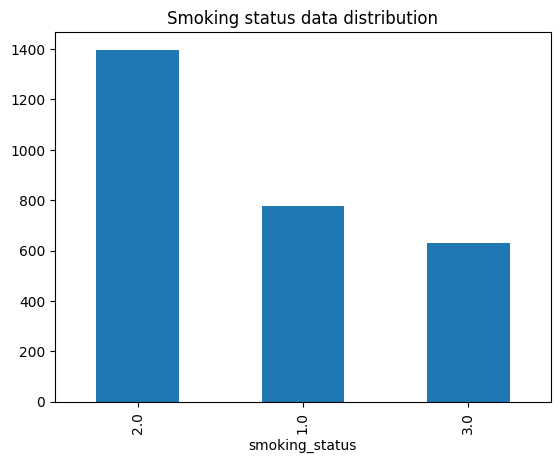

In [99]:
df_smoking_status_imputed.smoking_status.value_counts().plot(kind='bar')
plt.title('Smoking status data distribution')
plt.show()

##### Dropping id column

In [100]:
del df['id']
del df_smoking_status_imputed['id']

### Resampling

#### Random oversampling of Positive stroke class

In [101]:
majority_class = df[df['stroke'] == 0]
minority_class = df[df['stroke'] == 1]

minority_upsampled = resample(minority_class,
                               replace=True,
                               n_samples=len(majority_class),
                               random_state=4)

df_balanced_random_oversampling = pd.concat([majority_class, minority_upsampled])

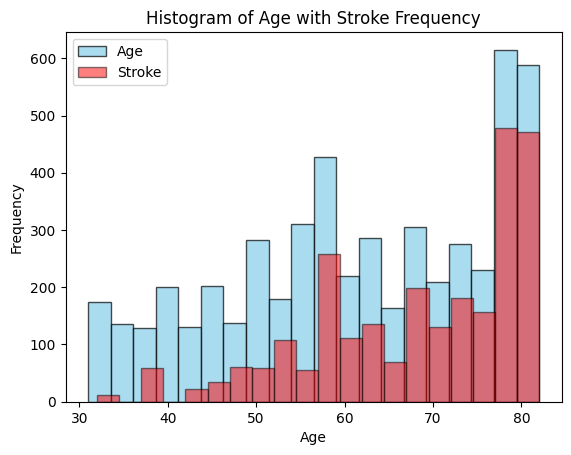

In [102]:
plt.hist(df_balanced_random_oversampling['age'], bins=20, color='skyblue', alpha=0.7, edgecolor='black', label='Age')
plt.hist(df_balanced_random_oversampling[df_balanced_random_oversampling['stroke'] == 1]['age'], bins=20, color='red', alpha=0.5, edgecolor='black', label='Stroke')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of Age with Stroke Frequency')
plt.legend()
plt.show()

#### SMOTE oversampling

In [103]:
from imblearn.over_sampling import SMOTE

X = df.drop('stroke', axis=1)
y = df['stroke']

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

df_balanced_SMOTE = pd.concat([pd.DataFrame(X_smote, columns=X.columns), pd.DataFrame(y_smote, columns=['stroke'])], axis=1)

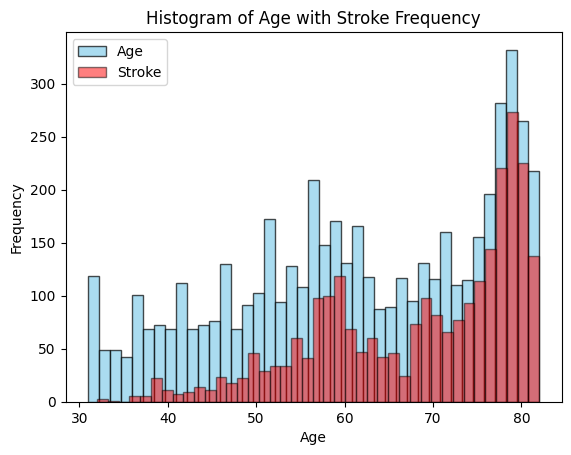

In [104]:
plt.hist(df_balanced_SMOTE['age'], bins=41, color='skyblue', alpha=0.7, edgecolor='black', label='Age')
plt.hist(df_balanced_SMOTE[df_balanced_SMOTE['stroke'] == 1]['age'], bins=41, color='red', alpha=0.5, edgecolor='black', label='Stroke')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of Age with Stroke Frequency')
plt.legend()
plt.show()

#### Copying Positive stroke class data records

In [105]:
df.stroke.value_counts()

stroke
0    2602
1     246
Name: count, dtype: int64

In [106]:
print('Multiply stroke class by:')
majority_class = df[df['stroke'] == 0]
minority_class = df[(df['stroke'] == 1)]
len_majority_class = len(majority_class)
len_minority_class = len(minority_class)
multiply_stroke_class_by = len_majority_class/len_minority_class
multiply_stroke_class_by = int(round(multiply_stroke_class_by))
print(multiply_stroke_class_by)

Multiply stroke class by:
11


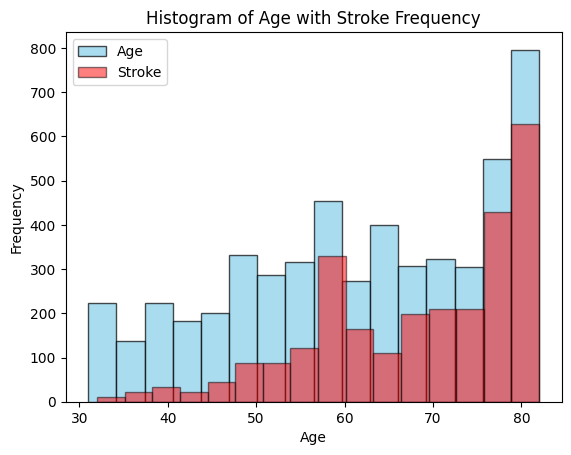

In [107]:
majority_class = df[df['stroke'] == 0]
minority_class = df[(df['stroke'] == 1)]
minority_oversampled = pd.concat([minority_class] * multiply_stroke_class_by, ignore_index=True)
df_balanced_triple_stroke = pd.concat([majority_class, minority_oversampled])
df_balanced_triple_stroke = df_balanced_triple_stroke.sample(frac=1, random_state=65000).reset_index(drop=True)

plt.hist(df_balanced_triple_stroke['age'], bins=16, color='skyblue', alpha=0.7, edgecolor='black', label='Age')
plt.hist(df_balanced_triple_stroke[df_balanced_triple_stroke['stroke'] == 1]['age'], bins=16, color='red', alpha=0.5, edgecolor='black', label='Stroke')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of Age with Stroke Frequency')
plt.legend()
plt.show()

## Correlation & Association

#### Heatmap

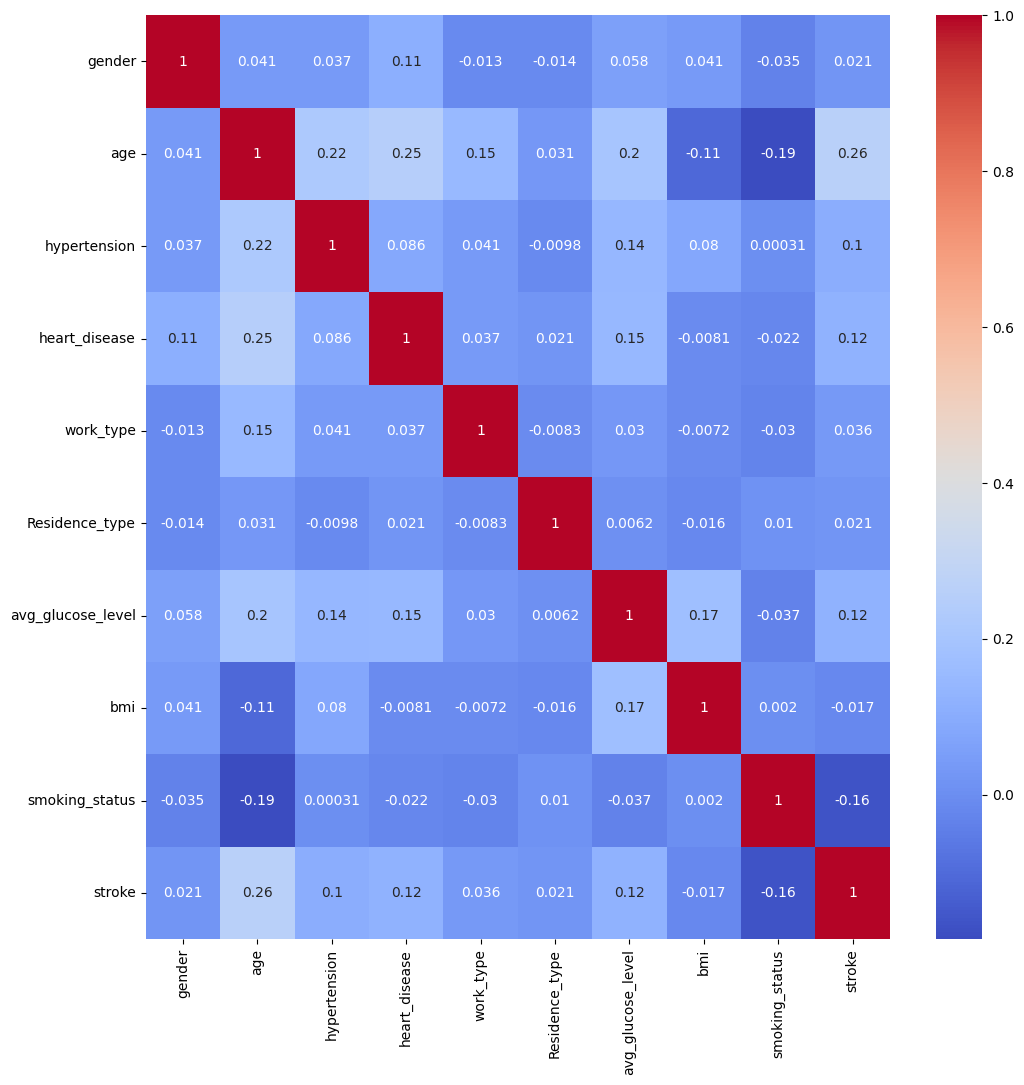

In [108]:
cor = df.corr()
fig,ax = plt.subplots(figsize=(12,12))
sns.heatmap(cor,annot=True,ax=ax,cmap='coolwarm');

#### Correlation between categorical binary variable *stroke* and continuous variables *age*, *glucose_level*, and *bmi*

In [109]:
continuous_vars = ['age', 'avg_glucose_level', 'bmi']

binary_vars = ['stroke']

df_without_null_bmi = df.dropna()

for continuous_var in continuous_vars:
    print(f'Point-biserial correlation coefficients for {continuous_var}:')
    for binary_var in binary_vars:
        # Calculate the point-biserial correlation coefficient
        correlation_coefficient, p_value = pointbiserialr(df_without_null_bmi[continuous_var], df_without_null_bmi[binary_var])
        print(f'{binary_var}: {correlation_coefficient:.4f} (p-value: {p_value:.4f})')
    print('\n')

Point-biserial correlation coefficients for age:
stroke: 0.2618 (p-value: 0.0000)


Point-biserial correlation coefficients for avg_glucose_level:
stroke: 0.1223 (p-value: 0.0000)


Point-biserial correlation coefficients for bmi:
stroke: -0.0168 (p-value: 0.3693)




There is a significant correlation between :  
- **stroke and age (23%)**, and   
- **stroke and average glucose level (13%)**

After bmi data imputation, 

#### Variables associated with age

**Age** strongly correlates with :
- **average glucose level (24%)** and  
- **bmi (28%)**

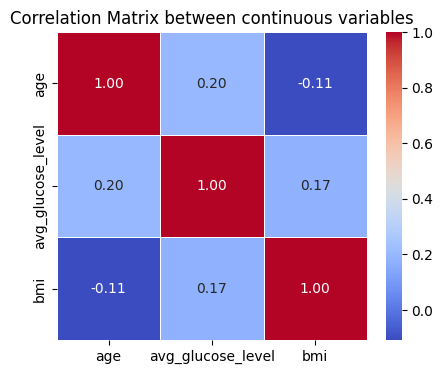

In [110]:
continuous_df = df[continuous_vars].copy()
continuous_df.corr(method='pearson')

correlation_matrix = continuous_df.corr()
plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix between continuous variables')
plt.show()

Age correlation with categorical variables:

In [111]:
continuous_vars = ['age']

binary_vars = ['gender', 'hypertension', 'heart_disease', 'Residence_type', 'work_type', 'smoking_status']

for continuous_var in continuous_vars:
    print(f'Point-biserial correlation coefficients for {continuous_var}:')
    for binary_var in binary_vars:
        # Calculate the point-biserial correlation coefficient
        correlation_coefficient, p_value = pointbiserialr(df[continuous_var], df[binary_var])
        print(f'{binary_var}: {correlation_coefficient:.4f} (p-value: {p_value:.4f})')
    print('\n')

Point-biserial correlation coefficients for age:
gender: 0.0406 (p-value: 0.0302)
hypertension: 0.2177 (p-value: 0.0000)
heart_disease: 0.2533 (p-value: 0.0000)
Residence_type: 0.0306 (p-value: 0.1031)
work_type: 0.1493 (p-value: 0.0000)
smoking_status: -0.1856 (p-value: 0.0000)




**Age** has a significant association with :
- **hypertension (27%)**,  
- **heart_disease (26%)**,
- **work_type (29%)**, and
- **smoking_status (21%)**

#### Correlation between categorical binary variable *stroke* and categorical binary & nominal variables *gender*, *hypertension*, *heart_disease*, *Residence_type*, *work_type*, and *smoking_status*

In [112]:
categorical_variables = ['gender', 'hypertension', 'heart_disease', 'work_type', 'Residence_type', 'smoking_status']

for var in categorical_variables:
    contingency_table = pd.crosstab(df['stroke'], df[var])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-squared test for {var}:")
    print(f"Chi2 Statistic: {chi2}")
    print(f"P-value: {p}")
    print("")

Chi-squared test for gender:
Chi2 Statistic: 1.0549487559746282
P-value: 0.3043700905571794

Chi-squared test for hypertension:
Chi2 Statistic: 28.58982213176976
P-value: 8.94511230613984e-08

Chi-squared test for heart_disease:
Chi2 Statistic: 41.20137890806463
P-value: 1.3732563033791207e-10

Chi-squared test for work_type:
Chi2 Statistic: 3.9533524329055014
P-value: 0.1385289130784343

Chi-squared test for Residence_type:
Chi2 Statistic: 1.113682621342933
P-value: 0.29128282710690456

Chi-squared test for smoking_status:
Chi2 Statistic: 488.36953608819545
P-value: 1.581625202822347e-105



**Stroke** has a significant association with:  
- **smoking_status**,  
- **hypertension**, 
- **heart_disease**, 
- **work_type**

## Classification for unknown smocking status

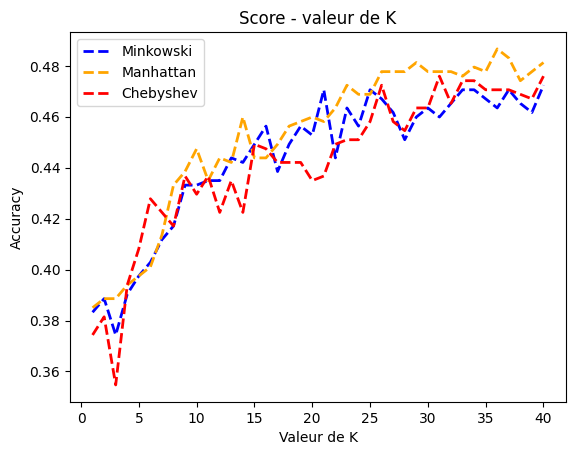

In [113]:
df_smoke = df
df_smoke = df_smoke[df_smoke.smoking_status != 0]
X_train_smoke, X_test_smoke, y_train_smoke, y_test_smoke = train_test_split(df_smoke.drop('smoking_status', axis=1),df_smoke['smoking_status'],test_size = .2)

scaler_smoke = StandardScaler()
X_train_smoke = scaler_smoke.fit_transform(X_train_smoke)
X_test_smoke = scaler_smoke.transform(X_test_smoke)

score_minko = []
score_man = []
score_cheb = []

for k in range(1, 41):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_smoke, y_train_smoke)
    score_minko.append(knn.score(X_test_smoke, y_test_smoke))

for k in range(1, 41):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k, metric='manhattan')
    knn.fit(X_train_smoke, y_train_smoke)
    score_man.append(knn.score(X_test_smoke, y_test_smoke))
    
for k in range(1, 41):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k, metric='chebyshev')
    knn.fit(X_train_smoke, y_train_smoke)
    score_cheb.append(knn.score(X_test_smoke, y_test_smoke))


plt.plot(range(1, 41), score_minko, color='blue', linestyle='dashed', lw=2, label='Minkowski')
plt.plot(range(1, 41), score_man, color='orange', linestyle='dashed', lw=2, label='Manhattan')
plt.plot(range(1, 41), score_cheb, color='red', linestyle='dashed', lw=2, label='Chebyshev')
plt.title('Score - valeur de K')  
plt.xlabel('Valeur de K')  
plt.ylabel('Accuracy') 
plt.legend();


In [114]:
clf = svm.SVC(gamma=0.01,  kernel='poly')
parametres = {'C':[0.1,1,10], 'kernel':['rbf','linear', 'poly'], 'gamma':[0.001, 0.1, 0.5]}

grid_clf = model_selection.GridSearchCV(estimator=clf, param_grid=parametres,verbose=3)

#grille = grid_clf.fit(X_train_smoke,y_train_smoke)

#print(grid_clf.best_params_)
#{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


In [115]:
rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
#CV_rfc.fit(X_train_smoke, y_train_smoke)
#CV_rfc.best_params_
#{'criterion': 'gini',
# 'max_depth': 7,
# 'max_features': 'sqrt',
# 'n_estimators': 200}

In [116]:
LR=LogisticRegression(random_state=42)
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'max_iter' : [100,300,600,1000]
}
CV_rfc = GridSearchCV(estimator=LR, param_grid=param_grid, cv= 5)
#CV_rfc.fit(X_train_smoke, y_train_smoke)
#CV_rfc.best_params_
#{'C': 1, 'max_iter': 100, 'penalty': 'l2'}

In [117]:
"""
X_train, y_train = ADASYN().fit_resample(X_train_smoke, y_train_smoke)
X_train, y_train = SMOTE().fit_resample(X_train_smoke, y_train_smoke)
print(y_train.value_counts())
over = RandomOverSampler(sampling_strategy={2:1500,1:800,3:800})
under = RandomUnderSampler(sampling_strategy={2:800,1:800,3:800})
X_train, y_train = over.fit_resample(X_train_smoke, y_train_smoke)
X_train, y_train = under.fit_resample(X_train_smoke, y_train_smoke)
print(y_train.value_counts())
"""

clf1 = KNeighborsClassifier(n_neighbors=40, metric='chebyshev')
clf2 = RandomForestClassifier(criterion='entropy',max_depth=6,max_features='sqrt',n_estimators=500)
clf3 = LogisticRegression(max_iter=100,C=0.001,penalty='l2')
#clf4 = svm.SVC(C=0.1 ,gamma=0.001,  kernel='rbf')
clf5 = DecisionTreeClassifier(ccp_alpha= 0.1,criterion='gini', max_depth= 5, max_features= 'sqrt')

vclf = VotingClassifier(estimators=[('knn', clf1), ('rf', clf2), ('lr', clf3), ('DT', clf5)], voting='soft')

cv3 = KFold(n_splits=3, random_state=111, shuffle=True)

for clf, label in zip([clf1, clf2, clf3, clf5, vclf], ['KNN', 'Random Forest', 'Logistic Regression', 'SVC','Decision Tree', 'Voting Classifier']):
    scores = cross_validate(clf, X_train_smoke, y_train_smoke, cv=cv3, scoring=['accuracy','f1_weighted'])
    print("[%s]: \n Accuracy: %0.2f (+/- %0.2f)" % (label, scores['test_accuracy'].mean(), scores['test_accuracy'].std()),
          "F1 score: %0.2f (+/- %0.2f)" % (scores['test_f1_weighted'].mean(), scores['test_f1_weighted'].std()))

print("--------------------------------------------")

sclf = StackingClassifier(estimators=[('knn', clf1), ('rf', clf2), ('lr', clf3),('DT',clf5)], final_estimator=clf5)

scores = cross_validate(sclf, X_train_smoke, y_train_smoke, cv=cv3, scoring=['accuracy', 'f1_weighted'])

print("[StackingClassifier]: \n Accuracy: %0.2f (+/- %0.2f)\n" % (scores['test_accuracy'].mean(), scores['test_accuracy'].std()),
      "F1 score: %0.2f (+/- %0.2f)" % (scores['test_f1_weighted'].mean(), scores['test_f1_weighted'].std()))

[KNN]: 
 Accuracy: 0.49 (+/- 0.00) F1 score: 0.38 (+/- 0.00)
[Random Forest]: 
 Accuracy: 0.51 (+/- 0.01) F1 score: 0.38 (+/- 0.01)
[Logistic Regression]: 
 Accuracy: 0.50 (+/- 0.00) F1 score: 0.34 (+/- 0.01)
[SVC]: 
 Accuracy: 0.50 (+/- 0.00) F1 score: 0.34 (+/- 0.01)
[Decision Tree]: 
 Accuracy: 0.50 (+/- 0.00) F1 score: 0.34 (+/- 0.00)
--------------------------------------------
[StackingClassifier]: 
 Accuracy: 0.50 (+/- 0.00)
 F1 score: 0.34 (+/- 0.01)


In [118]:
clf1.fit(X_train_smoke, y_train_smoke)
y_pred = clf1.predict(X_test_smoke)
pd.crosstab(y_test_smoke, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite   1    2  3
Classe réelle             
1               21  141  1
2               21  242  5
3                8  118  4

In [119]:
print(classification_report(y_test_smoke, y_pred))

              precision    recall  f1-score   support

           1       0.42      0.13      0.20       163
           2       0.48      0.90      0.63       268
           3       0.40      0.03      0.06       130

    accuracy                           0.48       561
   macro avg       0.43      0.35      0.29       561
weighted avg       0.45      0.48      0.37       561



In [120]:
df['predict'] = clf1.predict(df.drop('smoking_status', axis=1))
df.loc[df['smoking_status'] == 0,'smoking_status'] = df.loc[df['smoking_status'] == 0, 'predict']
df=df.drop(['predict'],axis=1)

/Users/saganne.chevalier/anaconda3/envs/Data_1/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning:

X has feature names, but KNeighborsClassifier was fitted without feature names



## Supervised classification (with 1 feature)

#### Random Forrest

##### Algorithm

In [121]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('stroke', axis=1),df['stroke'],test_size = .2)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

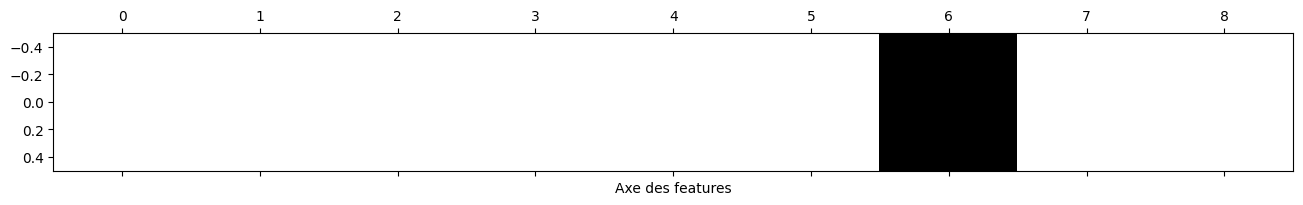

In [122]:
rfc1 = RandomForestClassifier()
rfe = RFE(estimator=rfc1, step=1, n_features_to_select = 1)
rfe.fit(X_train, y_train)
mask = rfe.get_support()
plt.matshow(mask.reshape(1,-1), cmap = 'gray_r')
plt.xlabel('Axe des features');

In [123]:
df.head()

gender   age  hypertension  heart_disease  work_type  Residence_type  \
0       1  67.0             0              1          2               1   
1       0  61.0             0              0          3               0   
2       1  80.0             0              1          2               0   
3       0  49.0             0              0          2               1   
4       0  79.0             1              0          3               0   

   avg_glucose_level   bmi  smoking_status  stroke  
0             228.69  36.6               1       1  
1             202.21  39.2               2       1  
2             105.92  32.5               2       1  
3             171.23  34.4               3       1  
4             174.12  24.0               2       1

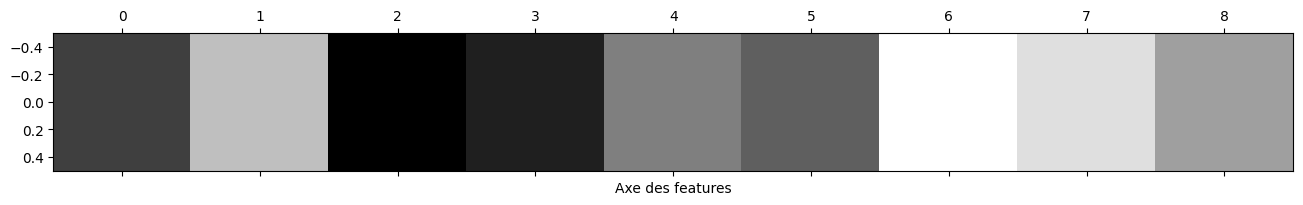

In [124]:
ranking = rfe.ranking_
plt.matshow(ranking.reshape(1,-1), cmap = 'gray_r')
plt.xlabel('Axe des features');
plt.show();

##### Evaluation

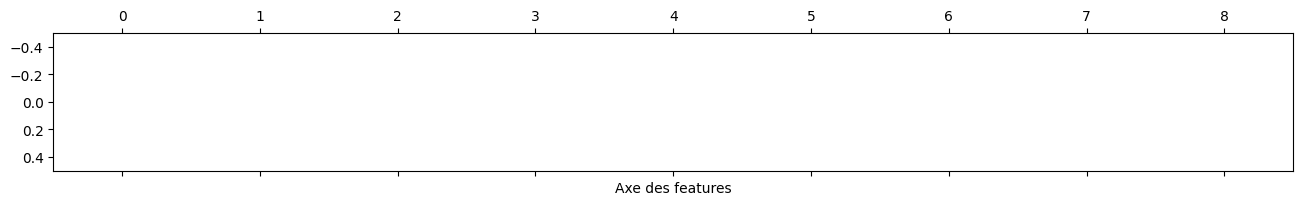

In [125]:
rfc = RandomForestClassifier()

crossval = KFold(n_splits = 5, random_state = 2, shuffle = True)
rfecv = RFECV(estimator=rfc, cv = crossval, step=1)
rfecv.fit(X_train, y_train)

mask = rfecv.get_support()
plt.matshow(mask.reshape(1,-1), cmap = 'gray_r')
plt.xlabel('Axe des features');
plt.show();


Nombre de features retenus : 9


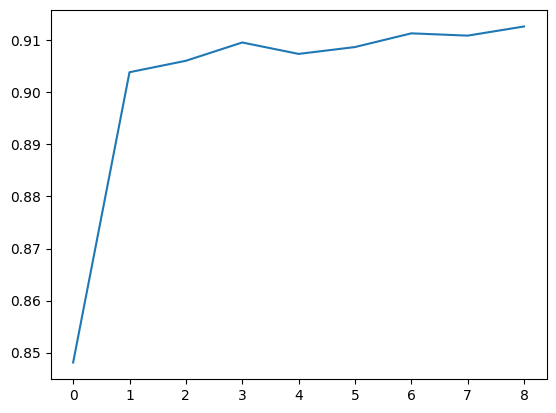

In [126]:
plt.plot(rfecv.cv_results_['mean_test_score']);
print("Nombre de features retenus :", rfecv.n_features_)

In [127]:
rfecv.cv_results_['mean_test_score']

array([0.84811452, 0.90385772, 0.90605263, 0.90957008, 0.90737517,
       0.90869096, 0.91132543, 0.91088587, 0.91264315])

In [128]:
rfc_X = df[['avg_glucose_level']]
rfc_y = df['stroke']
rfc_X_train, rfc_X_test, rfc_y_train, rfc_y_test = train_test_split(rfc_X, rfc_y, test_size=0.2, random_state=2)
scaler_smoke = StandardScaler()
rfc_X_train = scaler_smoke.fit_transform(X_train)
rfc_X_test = scaler_smoke.transform(X_test)

rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [1,10,25],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [10,30,50,100],
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid,scoring = 'recall')
CV_rfc.fit(rfc_X_train, rfc_y_train)
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 30,
 'max_features': 'sqrt',
 'n_estimators': 1}

In [129]:
rfc=RandomForestClassifier(criterion='gini',max_depth=30,max_features='sqrt',n_estimators=1,random_state=42)
rfc.fit(rfc_X_train, rfc_y_train)
y_pred = rfc.predict(rfc_X_test)
pd.crosstab(rfc_y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite    0   1
Classe réelle          
0               475  41
1                51   3

In [130]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.92      0.92       520
           1       0.09      0.08      0.09        50

    accuracy                           0.85       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.84      0.85      0.84       570



#### Binary Logistic Regression

##### Algorithm

In [131]:
lr_X = df[['hypertension']] # independent variable
lr_y = df['stroke'] # outcome variable

lr_X_train, lr_X_test, lr_y_train, lr_y_test = train_test_split(lr_X, lr_y, test_size=0.2, random_state=2)

model = LogisticRegression()
model.fit(lr_X_train, lr_y_train)

lr_y_pred = model.predict(lr_X_test)

lr_accuracy = accuracy_score(lr_y_test, lr_y_pred)
print("Accuracy:", lr_accuracy)


Accuracy: 0.9052631578947369


Accuracy

An accuracy of approximately 91% suggests that the logistic regression model performs relatively well on the test data. However, accuracy alone may not provide a complete picture.

Confusion matrix

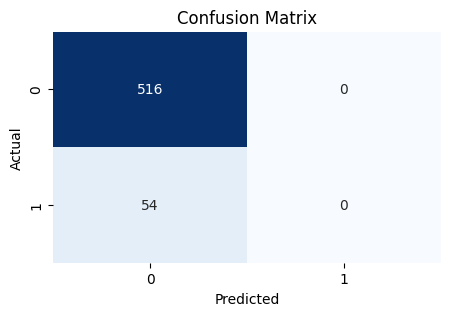

[[516   0]
 [ 54   0]]


In [132]:
lr_conf_matrix = confusion_matrix(lr_y_test, lr_y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(lr_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
print(lr_conf_matrix)

**Confusion matrix indicates:**  
True Negatives (TN): 516  
False Negatives (FN): 0  
True Positives (TP): 0  
False Positives (FP): 54

A confusion matrix with no true positives (TP) suggests that the model predicted all instances as the negative class (no stroke) and did not predict any instances as the positive class (stroke). This could indicate a **problem with class imbalance**.

In [133]:
print(classification_report(lr_y_test, lr_y_pred, zero_division=True))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95       516
           1       1.00      0.00      0.00        54

    accuracy                           0.91       570
   macro avg       0.95      0.50      0.48       570
weighted avg       0.91      0.91      0.86       570



##### Algorithm using balanced data (random oversampling)

In [134]:
lr_X = df_balanced_random_oversampling[['avg_glucose_level']] # independent variable
lr_y = df_balanced_random_oversampling['stroke'] # outcome variable

lr_X_train, lr_X_test, lr_y_train, lr_y_test = train_test_split(lr_X, lr_y, test_size=0.2, random_state=2)

model = LogisticRegression()
model.fit(lr_X_train, lr_y_train)

lr_y_pred = model.predict(lr_X_test)

lr_accuracy = accuracy_score(lr_y_test, lr_y_pred)
print(classification_report(lr_y_test, lr_y_pred, zero_division=True))

              precision    recall  f1-score   support

           0       0.59      0.75      0.66       536
           1       0.63      0.45      0.52       505

    accuracy                           0.60      1041
   macro avg       0.61      0.60      0.59      1041
weighted avg       0.61      0.60      0.59      1041



/Users/saganne.chevalier/anaconda3/envs/Data_1/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but LogisticRegression was fitted with feature names



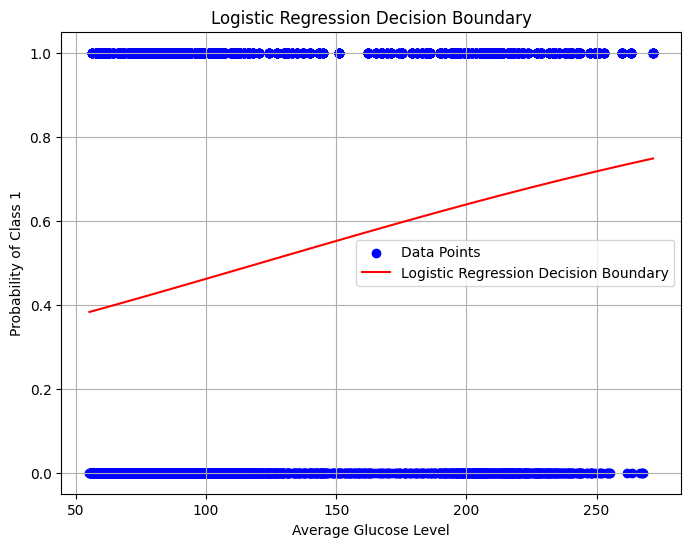

In [135]:
model = LogisticRegression()
model.fit(lr_X, lr_y)

x_values = np.linspace(lr_X.min(), lr_X.max(), 100).reshape(-1, 1)
y_values = model.predict_proba(x_values)[:, 1]

plt.figure(figsize=(8, 6))
plt.scatter(lr_X, lr_y, color='b', label='Data Points')
plt.plot(x_values, y_values, color='r', label='Logistic Regression Decision Boundary')
plt.xlabel('Average Glucose Level')
plt.ylabel('Probability of Class 1')
plt.title('Logistic Regression Decision Boundary')
plt.legend()
plt.grid(True)
plt.show()


##### Algorithm using balanced data (SMOTE)

In [136]:
lr_X = df_balanced_SMOTE[['avg_glucose_level']] # independent variable
lr_y = df_balanced_SMOTE['stroke'] # outcome variable

lr_X_train, lr_X_test, lr_y_train, lr_y_test = train_test_split(lr_X, lr_y, test_size=0.2, random_state=25)
model = LogisticRegression()
model.fit(lr_X_train, lr_y_train)
lr_y_pred = model.predict(lr_X_test)

lr_accuracy = accuracy_score(lr_y_test, lr_y_pred)
print(classification_report(lr_y_test, lr_y_pred, zero_division=True))

              precision    recall  f1-score   support

           0       0.56      0.77      0.65       528
           1       0.62      0.38      0.47       513

    accuracy                           0.58      1041
   macro avg       0.59      0.58      0.56      1041
weighted avg       0.59      0.58      0.56      1041



##### Algorithm using balanced data (data copying)

In [137]:
lr_X = df_balanced_triple_stroke[['avg_glucose_level']] # independent variable
lr_y = df_balanced_triple_stroke['stroke'] # outcome variable

lr_X_train, lr_X_test, lr_y_train, lr_y_test = train_test_split(lr_X, lr_y, test_size=0.2, random_state=25)
model = LogisticRegression()
model.fit(lr_X_train, lr_y_train)
lr_y_pred = model.predict(lr_X_test)

lr_accuracy = accuracy_score(lr_y_test, lr_y_pred)
print(classification_report(lr_y_test, lr_y_pred, zero_division=True))

              precision    recall  f1-score   support

           0       0.56      0.74      0.64       527
           1       0.63      0.44      0.52       535

    accuracy                           0.59      1062
   macro avg       0.60      0.59      0.58      1062
weighted avg       0.60      0.59      0.58      1062



#### Voting classifier

In [139]:
vc_X = df[['avg_glucose_level']]
vc_y = df['stroke']
rfc=RandomForestClassifier(criterion='gini',max_depth=30,max_features='sqrt',n_estimators=1,random_state=42)
model = LogisticRegression()
vclf = VotingClassifier(estimators=[('RFC', rfc), ('LR', model)], voting='soft')

vc_X_train, vc_X_test, vc_y_train, vc_y_test = train_test_split(vc_X, vc_y, test_size=0.2, random_state=2)
scaler = StandardScaler()
rfc_X_train = scaler.fit_transform(X_train)
rfc_X_test = scaler.transform(X_test)

rfc.fit(vc_X_train, vc_y_train)
y_pred = rfc.predict(vc_X_test)
pd.crosstab(vc_y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite    0   1
Classe réelle          
0               476  40
1                54   0

In [140]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       520
           1       0.10      0.08      0.09        50

    accuracy                           0.86       570
   macro avg       0.51      0.51      0.51       570
weighted avg       0.84      0.86      0.85       570



## Supervised classification (with multiple features)

#### Logistic Regression

Multifeature logistic regresion using *data copying* method to balance the stroke classes:

In [ ]:
X = df_balanced_triple_stroke[['age', 'avg_glucose_level', 'smoking_status', 'hypertension', 'heart_disease', 'work_type']]
y = df_balanced_triple_stroke['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(max_iter=5000)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

Multifeature logistic regresion using *random oversampling* method to balance the stroke classes

In [ ]:
X = df_balanced_random_oversampling[['age', 'avg_glucose_level', 'smoking_status', 'hypertension', 'heart_disease', 'work_type']]
y = df_balanced_random_oversampling['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(max_iter=5000)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

Multifeature logistic regresion using *SMOTE* method to balance the stroke classes

In [ ]:
X = df_balanced_SMOTE[['age', 'avg_glucose_level', 'smoking_status', 'hypertension', 'heart_disease', 'work_type']]
y = df_balanced_SMOTE['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(max_iter=5000)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

- Average glucose level slightly improves the recall in Positive stroke class.  
- Hypertension slightly improves the accuracy.  
- Heart disease slightly improves precision and recall in positive stroke class but slightlyworsens recall in negative stroke class.
- Work type slightly improves precision in negative stroke class and recall in positive stroke class
- BMI slightly ameliorates the precision and recall in the positive stroke class (indicating true positives), but overall accuracy remains the same 78%.  

Model performs relatively well in predicting both classes and overall accuracy of the model is 78%.  
The best data oversampling method is SMOTE.

In [ ]:
X = df_balanced_SMOTE[['age', 'smoking_status']]
y = df_balanced_SMOTE['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(max_iter=5000)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

Similar results are obtained with only two independent variables - age and smoking status

Removing data records up to age 32 deteriorates the results compared to data deletion up to the age >30. 

Adding more records where (removing records up to age 20) also deteriorates the results compared to data deletion up to the age 30. (accuracy 72%, positive class precision 69%, recall 74%) 

Imputing smoking_status deteriorates results.

#### Random Forest Classifier

In [ ]:
rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [1,10,25],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [10,30,50,100],
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid,scoring = 'recall')
CV_rfc.fit(X_train, y_train)
CV_rfc.best_params_

In [ ]:
rfc=RandomForestClassifier(criterion='gini',max_depth=30,max_features='sqrt',n_estimators=1,random_state=42)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

In [ ]:
print(classification_report(y_test, y_pred))

#### Voting classifier

In [141]:

rfc=RandomForestClassifier(criterion='gini',max_depth=30,max_features='sqrt',n_estimators=1,random_state=42)
model = LogisticRegression(max_iter=5000)
vclf = VotingClassifier(estimators=[('RFC', rfc), ('LR', model)], voting='soft')



rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite    0   1
Classe réelle          
0               488  32
1                41   9

In [142]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       520
           1       0.22      0.18      0.20        50

    accuracy                           0.87       570
   macro avg       0.57      0.56      0.56       570
weighted avg       0.86      0.87      0.87       570

